In [76]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import time

from scipy.optimize import curve_fit
from scipy          import stats

import copy

import ROOT

import warnings

In [3]:
dir        = "DATA/"
file1      = 'BHBH_Delay_Time.csv'

BHBH       = pd.read_csv(dir+file1)

# compute total mass and reduced mass
BHBH[  'Mass_total'] = BHBH.Mass_0 + BHBH.Mass_1
BHBH['Mass_reduced'] = BHBH.Mass_0 * BHBH.Mass_1 / (BHBH.Mass_0 + BHBH.Mass_1)

In [89]:
BHBH.head()
alpha_df.keys()

dict_keys([0.5, 1.0, 3.0, 5.0])

In [92]:
def power_law(x, a, b):
    '''
    Model for power law fit.

    Inputs:
        - x: independent variable
        - a: exponent
        - b: parameter to multiply by

    Output:
        - result of power law computation
    '''
    return x ** a * 10 ** b

def chisqr(obs, exp):
    '''
    Chisquare computation (Person's chi square)

    Inputs:
        - obs: array of observed values
        - exp: array of expected values

    Outputs:
        - value of chi square
        - p-value
    '''
    chisqr = 0
    for i in range(len(obs)):
        chisqr+=((obs[i]-exp[i])**2)/obs[i]
    return chisqr, stats.chi2.sf(chisqr, len(obs))

# t-student distribution
tinv = lambda p, df: abs(stats.t.ppf(p/2, df))

def plot_complete(df, column, Delay=False, bins=100):
    '''
    Plot the whole dataset.
    
    Inputs:
        - df: dataframe with the data
        - column: column you want to plot (usually Delay_Time or GWtime)
        - Delay: boolean, if true plot the sum of merger time and BWorldtime,
                 else plot just the merger time distribution
        - bins: number of bins in the histogram
        
    Outputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
    '''
    fig, ax = plt.subplots(figsize=(15,7))
    
    if Delay==False:
        BWorldtime = 0
    else:
        BWorldtime = df['BWorldtime']

    #b = np.histogram_bin_edges(BHBH[(BHBH.GWtime<1e18)].GWtime, bins='rice') # does not work with bind='fd'
    b = np.logspace(np.log10(min(df[column]+BWorldtime)), np.log10(max(df[column]+BWorldtime)), bins)
    entries, edges, _ = ax.hist(df[column]+BWorldtime, bins=b, density=True)

    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_title('Distribution of the Merger times')
    ax.set_xlabel('Delay Time [Myr]')
    ax.set_ylabel('PDF')
    plt.show()
    
    return bin_centers, entries

def fit_complete(bin_centers, entries, xmin=0, xmax=1e30):
    '''
    Fit the distribution with a unique function.
    
    Inputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
        - xmin: value in which the fit should start
        - xmax: value in which the fit should end
    '''
    
    fig, ax = plt.subplots(figsize=(15,7))

    mask = np.where((bin_centers>xmin) & (bin_centers<xmax) & (entries!=0))

    results = stats.linregress(np.log10(bin_centers[mask]), np.log10(entries[mask]))

    ax.scatter(np.log10(bin_centers[mask]), np.log10(entries[mask]), s=30, marker='x', label='Real data', color='black')
    ax.plot(np.log10(bin_centers[mask]), results.intercept + results.slope*np.log10(bin_centers[mask]), '--', lw=3, label='Power Law fit', color='red')

    ts = tinv(0.05, len(bin_centers[mask])-2)
    print(f"slope (95%):\t {results.slope:.6f} +/- {ts*results.stderr:.6f}")
    print(f"intercept (95%): {results.intercept:.6f}"
          f" +/- {ts*results.intercept_stderr:.6f}")

    chi2, p = stats.chisquare(results.intercept + results.slope*np.log10(bin_centers[mask]),
                                np.log10(entries[mask]), ddof=len(entries[mask]))

    print(f"chi2 statistic:\t{chi2:.5g}")
    print(f"p-value:       \t{p:.5g}\n")

    # get the covariance. Numpy conveniently provides the np.cov() method
    cov = np.cov(np.log10(bin_centers[mask]), np.log10(entries[mask]), ddof=2)
    b_hat = cov[0, 1] / cov[0, 0]
    a_hat = np.mean(np.log10(entries[mask]) - b_hat * np.log10(bin_centers[mask]))

    ssr = np.sum((np.log10(entries[mask]) - a_hat - b_hat * np.log10(bin_centers[mask]))**2)
    tss = np.sum((np.mean(np.log10(entries[mask])) - np.log10(entries[mask]))**2)

    rsq = 1 - ssr / tss

    print("R2 =", rsq, "\nR =", np.sqrt(rsq))
    print("Covariance matrix:\n", np.corrcoef(np.log10(bin_centers[mask]),np.log10(entries[mask]))) # check with the correlation matrix that R is the correlation coefficient
    print("\n\n")

    ax.set_xlabel('Delay Time [Myr]')
    ax.set_ylabel('PDF')

    ax.grid(ls='dotted')
    ax.legend(loc='upper right')

    plt.show()
    
    
def fit_range(bin_centers, entries, xstep = (0, 1e7, 1e19, 1e30)):
    '''
    Fit the distribution with a function defined by steps.
    
    Inputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
        - xstep: list of steps
    '''
    fig, ax = plt.subplots(figsize=(15,7))

    ax.scatter(np.log10(bin_centers[np.where(entries!=0)]), np.log10(entries[np.where(entries!=0)]), s=50, marker='x', label='Real data', c='black')
    for i in range(len(xstep)-1):

        print("----- FIT", i, "-----\n")

        mask = np.where((bin_centers>xstep[i]) & (bin_centers<xstep[i+1]) & (entries!=0))
        results = stats.linregress(np.log10(bin_centers[mask]), np.log10(entries[mask]))
        ax.plot(np.log10(bin_centers[mask]), results.intercept + results.slope*np.log10(bin_centers[mask]), '--', lw=3, label='Range '+str(i))

        ts = tinv(0.05, len(bin_centers[mask])-2)
        print(f"slope (95%):\t {results.slope:.6f} +/- {ts*results.stderr:.6f}")
        print(f"intercept (95%): {results.intercept:.6f}"
          f" +/- {ts*results.intercept_stderr:.6f}")

        chi2, p = stats.chisquare(results.intercept + results.slope*np.log10(bin_centers[mask]),
                                  np.log10(entries[mask]), ddof=len(entries[mask]))

        print(f"chi2 statistic:\t{chi2:.5g}")
        print(f"p-value:       \t{p:.5g}\n")


        # get the covariance. Numpy conveniently provides the np.cov() method
        cov = np.cov(np.log10(bin_centers[mask]), np.log10(entries[mask]), ddof=2)
        b_hat = cov[0, 1] / cov[0, 0]
        a_hat = np.mean(np.log10(entries[mask]) - b_hat * np.log10(bin_centers[mask]))

        ssr = np.sum((np.log10(entries[mask]) - a_hat - b_hat * np.log10(bin_centers[mask]))**2)
        tss = np.sum((np.mean(np.log10(entries[mask])) - np.log10(entries[mask]))**2)

        rsq = 1 - ssr / tss

        print("R2 =", rsq, "\nR =", np.sqrt(rsq))
        print("Covariance matrix:\n", np.corrcoef(np.log10(bin_centers[mask]),np.log10(entries[mask]))) # check with the correlation matrix that R is the correlation coefficient
        print("\n\n")

    ax.set_xlabel('Delay Time [Myr]')
    ax.set_ylabel('PDF')

    ax.grid(ls='dotted')
    ax.legend(loc='upper right')

    plt.show()

def Z_plot_figure(df, column, Delay=False, bins=100):
    '''
    Plot the whole dataset divided by values of Z.
    
    Inputs:
        - df: dict of dataframes with the data
        - column: column you want to plot (usually Delay_Time or GWtime)
        - Delay: boolean, if true plot the sum of merger time and BWorldtime,
                 else plot just the merger time distribution
        - bins: number of bins in the histogram
        
    Outputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
    '''
    bin_centers, entries = (np.empty(shape=(3,5), dtype=object) for i in range(2))
    
    BWorldtime = {elem : pd.Series for elem in df}
    if Delay==False:
        title = 'Merger Time'
        for key in df.keys():
            BWorldtime[key] = 0
    else:
        title = 'Delay Time'
        for key in df.keys():
            BWorldtime[key] = df[key]['BWorldtime']

    fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

    # indexes for the plot
    x, y = (0, 0)

    for key in df.keys():
        b                       = np.logspace(np.log10(min(df[key][column]+BWorldtime[key])), np.log10(max(df[key][column]+BWorldtime[key])), bins)
        entries[x,y], edges, _  = ax[x,y].hist(            df[key][column]+BWorldtime[key],   bins=b, density=True                           )

        # calculate bin centers
        bin_centers[x,y]          = 0.5 * (edges[:-1] + edges[1:])
        ax[x,y].set_xscale('log')
        ax[x,y].set_yscale('log')

        ax[x,y].set_title('Z = '+str(key))
        ax[x,y].set_xlabel('Delay Time [Myr]')
        ax[x,y].set_ylabel('PDF')

        y += 1
        if y == 5:
            x +=1
            y = 0

    plt.show
    
    return bin_centers, entries

def Z_fit_complete(bin_centers, entries, xmin=0, xmax=1e30):
    '''
    Fit the distributions with a unique function.
    
    Inputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
        - xmin: value in which the fit should start
        - xmax: value in which the fit should end
    '''
    results = np.empty(shape=(3,5), dtype=object)
    
    fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

    keys = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 
            0.001,   0.002,  0.004,  0.006,  0.008,
            0.01,    0.014,  0.017,   0.02,   0.03]

    # indexes for the plot
    x, y = (0, 0)

    for key in keys:
        ax[x,y].scatter(np.log10(bin_centers[x,y][entries[x,y]!=0]), np.log10(entries[x,y][entries[x,y]!=0]), s=30, marker='x', color='black')

        mask = np.where((bin_centers[x,y]>xmin) & (bin_centers[x,y]<xmax) & (entries[x,y]!=0))
        results[x,y] = stats.linregress(np.log10(bin_centers[x,y][mask]), np.log10(entries[x,y][mask]))

        ax[x,y].plot(np.log10(bin_centers[x,y][mask]), results[x,y].intercept + results[x,y].slope*np.log10(bin_centers[x,y][mask]), '--', lw=4)

        ax[x,y].set_title('Z = '+str(key))
        ax[x,y].set_xlabel('Delay Time [Myr] [log]')
        ax[x,y].set_ylabel('PDF [log]')
        ax[x,y].grid(ls='dotted')

        y += 1
        if y == 5:
            x +=1
            y = 0

    labels=['PDF', "Fit"]
    fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

    plt.show
    
def Z_fit_range(bin_centers, entries, xstep = (0, 1e7, 1e19, 1e30)):
    '''
    Fit the distribution with a function defined by steps.
    
    Inputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
        - xstep: list of steps
    '''
    results = np.empty(shape=(3,5,3), dtype=object)

    keys = [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 
            0.001,   0.002,  0.004,  0.006,  0.008,
            0.01,    0.014,  0.017,   0.02,   0.03]
    fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

    # indexes for the plot
    x, y = (0, 0)

    for key in keys:
        ax[x,y].scatter(np.log10(bin_centers[x,y][entries[x,y]!=0]), np.log10(entries[x,y][entries[x,y]!=0]), s=30, marker='x', color='black')

        mask = np.empty(shape=3, dtype=object)
        for i in range(len(results[x,y])):

            mask[i] = np.where((bin_centers[x,y]>xstep[i]) & (bin_centers[x,y]<xstep[i+1]) & (entries[x,y]!=0))
            results[x,y,i] = stats.linregress(np.log10(bin_centers[x,y][mask[i]]), np.log10(entries[x,y][mask[i]]))

            ax[x,y].plot(np.log10(bin_centers[x,y][mask[i]]), results[x,y,i].intercept + results[x,y,i].slope*np.log10(bin_centers[x,y][mask[i]]), '--', lw=4)

        ax[x,y].set_title('Z = '+str(key))
        ax[x,y].set_xlabel('Delay Time [Myr]')
        ax[x,y].set_ylabel('PDF')
        ax[x,y].grid(ls='dotted')

        y += 1
        if y == 5:
            x +=1
            y = 0

    labels=['PDF', "Fit range 1", "Fit range 2", "Fit range 3"]
    fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

    plt.show
    
def alpha_plot_figure(df, column, Delay=False, bins=100):
    '''
    Plot the whole dataset divided by values of alpha.
    
    Inputs:
        - df: dict of dataframes with the data
        - column: column you want to plot (usually Delay_Time or GWtime)
        - Delay: boolean, if true plot the sum of merger time and BWorldtime,
                 else plot just the merger time distribution
        - bins: number of bins in the histogram
        
    Outputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
    '''
    bin_centers, entries = (np.empty(shape=(2,2), dtype=object) for i in range(2))

    BWorldtime = {elem : pd.Series for elem in df}
    if Delay==False:
        title = 'Merger Time'
        for key in df.keys():
            BWorldtime[key] = 0
    else:
        title = 'Delay Time'
        for key in df.keys():
            BWorldtime[key] = df[key]['BWorldtime']

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))

    # indexes for the plot
    x, y = (0, 0)

    for key in df.keys():
        b                       = np.logspace(np.log10(min(df[key][column]+BWorldtime[key])), np.log10(max(df[key][column]+BWorldtime[key])), bins)
        entries[x,y], edges, _  = ax[x,y].hist(            df[key][column]+BWorldtime[key],   bins=b, density=True                           )

        # calculate bin centers
        bin_centers[x,y]          = 0.5 * (edges[:-1] + edges[1:])
        ax[x,y].set_xscale('log')
        ax[x,y].set_yscale('log')

        ax[x,y].set_title('α = '+str(key))
        ax[x,y].set_xlabel('Delay Time [Myr]')
        ax[x,y].set_ylabel('PDF')

        y += 1
        if y == 2:
            x +=1
            y = 0

    plt.show
    
    return bin_centers, entries

def alpha_fit_complete(bin_centers, entries, xmin=0, xmax=1e30):
    '''
    Fit the distribution with a unique function divided by values of alpha.
    
    Inputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
        - xmin: value in which the fit should start
        - xmax: value in which the fit should end
    '''
    results = np.empty(shape=(2,2), dtype=object)
    
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))

    keys = [0.5, 1.0, 3.0, 5.0]

    # indexes for the plot
    x, y = (0, 0)

    for key in keys:
        ax[x,y].scatter(np.log10(bin_centers[x,y][entries[x,y]!=0]), np.log10(entries[x,y][entries[x,y]!=0]), s=30, marker='x', color='black')

        mask = np.where((bin_centers[x,y]>xmin) & (bin_centers[x,y]<xmax) & (entries[x,y]!=0))
        results[x,y] = stats.linregress(np.log10(bin_centers[x,y][mask]), np.log10(entries[x,y][mask]))

        ax[x,y].plot(np.log10(bin_centers[x,y][mask]), results[x,y].intercept + results[x,y].slope*np.log10(bin_centers[x,y][mask]), '--', lw=4)

        ax[x,y].set_title('α = '+str(key))
        ax[x,y].set_xlabel('Delay Time [Myr] [log]')
        ax[x,y].set_ylabel('PDF [log]')
        ax[x,y].grid(ls='dotted')

        y += 1
        if y == 2:
            x +=1
            y = 0

    labels=['PDF', "Fit"]
    fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

    plt.show
    
def alpha_fit_range(bin_centers, entries, xstep = (0, 1e7, 1e19, 1e30)):
    '''
    Fit the distribution with a function defined by steps.
    
    Inputs:
        - bin_centers: center of each bin
        - entries: value of the pdf in each bin center
        - xstep: list of steps
    '''
    results = np.empty(shape=(2,2,3), dtype=object)

    keys = [0.5, 1.0, 3.0, 5.0]
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))

    # indexes for the plot
    x, y = (0, 0)

    for key in keys:
        ax[x,y].scatter(np.log10(bin_centers[x,y][entries[x,y]!=0]), np.log10(entries[x,y][entries[x,y]!=0]), s=30, marker='x', color='black')

        mask = np.empty(shape=3, dtype=object)
        for i in range(len(results[x,y])):

            mask[i] = np.where((bin_centers[x,y]>xstep[i]) & (bin_centers[x,y]<xstep[i+1]) & (entries[x,y]!=0))
            results[x,y,i] = stats.linregress(np.log10(bin_centers[x,y][mask[i]]), np.log10(entries[x,y][mask[i]]))

            ax[x,y].plot(np.log10(bin_centers[x,y][mask[i]]), results[x,y,i].intercept + results[x,y,i].slope*np.log10(bin_centers[x,y][mask[i]]), '--', lw=4)

        ax[x,y].set_title('α = '+str(key))
        ax[x,y].set_xlabel('Delay Time [Myr]')
        ax[x,y].set_ylabel('PDF')
        ax[x,y].grid(ls='dotted')

        y += 1
        if y == 2:
            x +=1
            y = 0

    labels=['PDF', "Fit range 1", "Fit range 2", "Fit range 3"]
    fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

    plt.show
    
def plot_all(df, column, Delay=False, bins=100):
    '''
    Plot all the distributions together.
    
    Inputs:
        - df: dict of dataframes with data
        - column: column to plot the distribution of
        - Delay: False: Plot merger time, true plot delay time
        - bins: number of bins
    '''

    BWorldtime = {elem : pd.Series for elem in df}
    if Delay==False:
        title = 'Merger Time'
        for key in df.keys():
            BWorldtime[key] = 0
    else:
        title = 'Delay Time'
        for key in df.keys():
            BWorldtime[key] = df[key]['BWorldtime']

    fig, ax = plt.subplots(figsize=(18,10))

    for key in df.keys():
        b                    = np.logspace(np.log10(min(df[key][column]+BWorldtime[key])), np.log10(max(df[key][column]+BWorldtime[key])), bins )
        entries, edges, _    = ax.hist(df[key][column]+BWorldtime[key], bins=b, histtype='step', lw=3, label='Z = '+str(key), density=True )

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_title(title)
    ax.set_xlabel('Delay Time [Myr]')
    ax.set_ylabel('PDF')
    ax.grid(ls='dotted')
    ax.legend(loc='upper right', ncol=3)
    #fig.savefig('figures/Delay_Time_Z.png')
    plt.show

### Merger time - Whole dataset

Using GWtime column

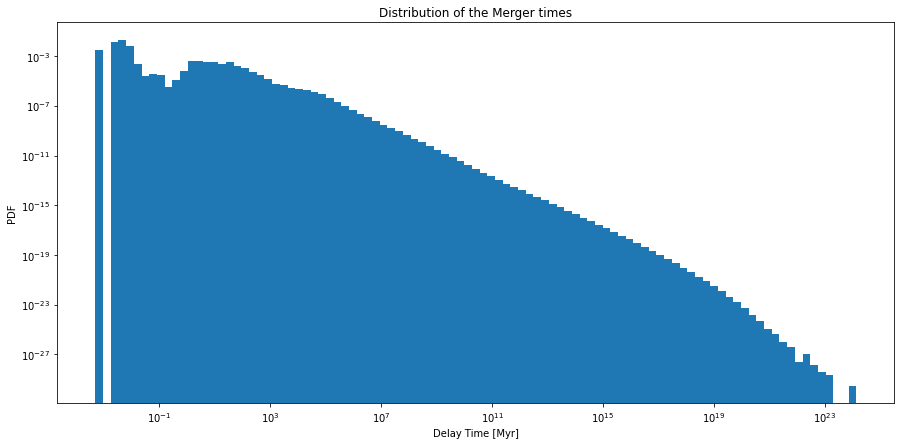

slope (95%):	 -1.003474 +/- 0.037919
intercept (95%): -2.517466 +/- 0.487529
chi2 statistic:	-30.764
p-value:       	nan

R2 = 0.967074485863873 
R = 0.9833994538659624
Covariance matrix:
 [[ 1.         -0.98339945]
 [-0.98339945  1.        ]]





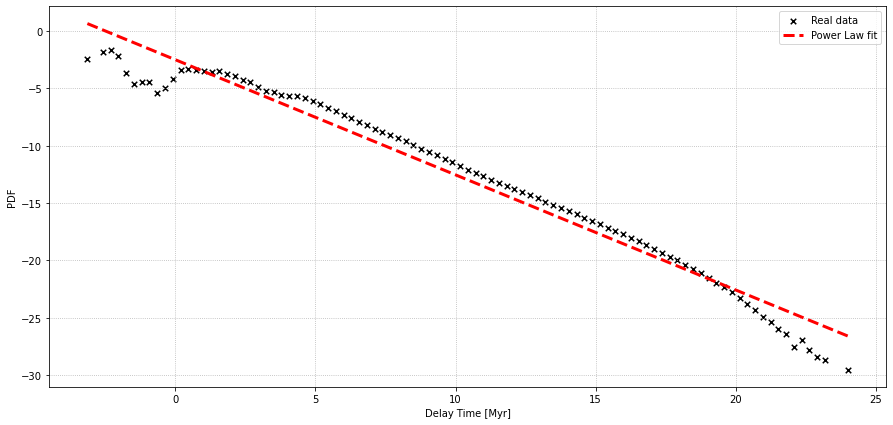

----- FIT 0 -----

slope (95%):	 -0.504303 +/- 0.102775
intercept (95%): -3.794781 +/- 0.361059
chi2 statistic:	-5.5651
p-value:       	nan

R2 = 0.7512478289828536 
R = 0.8667455387729743
Covariance matrix:
 [[ 1.         -0.86674554]
 [-0.86674554  1.        ]]



----- FIT 1 -----

slope (95%):	 -1.058084 +/- 0.009225
intercept (95%): -0.957959 +/- 0.123426
chi2 statistic:	-0.024882
p-value:       	nan

R2 = 0.9992365024735662 
R = 0.9996181783428942
Covariance matrix:
 [[ 1.         -0.99961818]
 [-0.99961818  1.        ]]



----- FIT 2 -----

slope (95%):	 -1.794504 +/- 0.099061
intercept (95%): 12.735462 +/- 2.094517
chi2 statistic:	-0.028811
p-value:       	nan

R2 = 0.9908110716571149 
R = 0.9953949325052418
Covariance matrix:
 [[ 1.         -0.99539493]
 [-0.99539493  1.        ]]





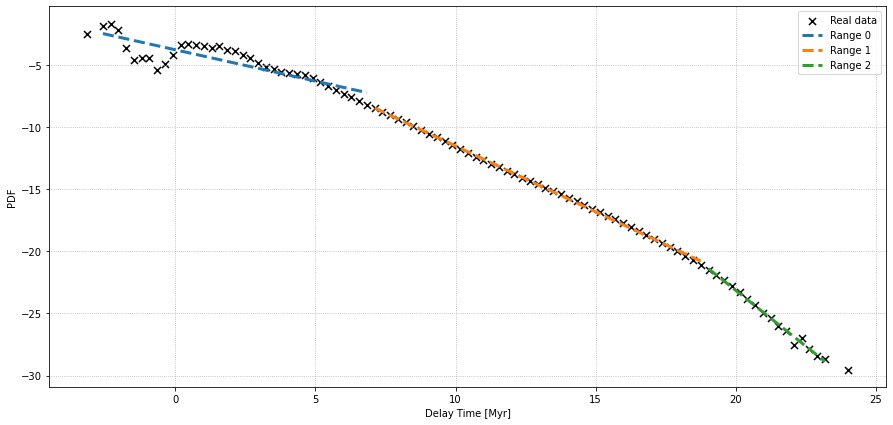

In [43]:
bin_centers, entries = plot_complete(BHBH, 'GWtime', False, 100)
fit_complete(bin_centers, entries)
fit_range(bin_centers, entries)

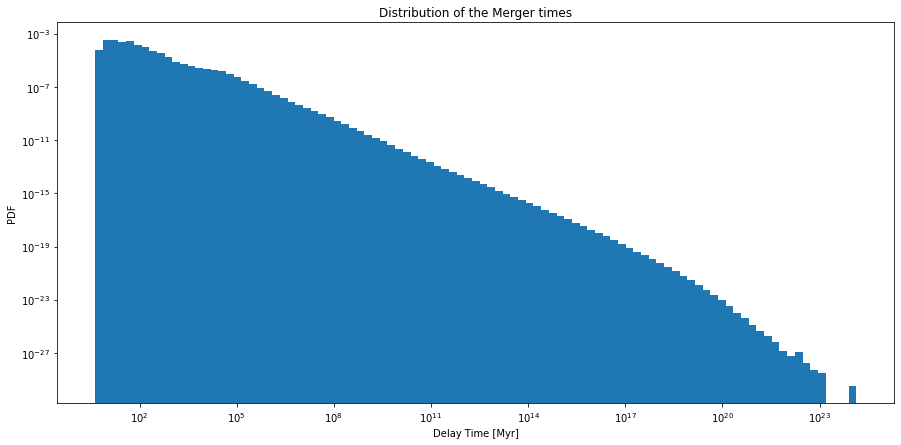

slope (95%):	 -1.108868 +/- 0.025251
intercept (95%): -0.866593 +/- 0.346838
chi2 statistic:	-6.1734
p-value:       	nan

R2 = 0.9877867885555426 
R = 0.9938746342248315
Covariance matrix:
 [[ 1.         -0.99387463]
 [-0.99387463  1.        ]]





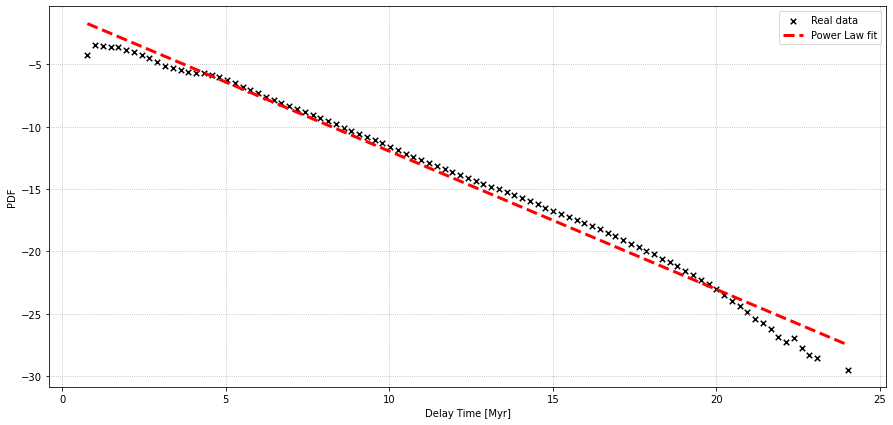

----- FIT 0 -----

slope (95%):	 -0.789689 +/- 0.062790
intercept (95%): -2.512847 +/- 0.268575
chi2 statistic:	-0.45783
p-value:       	nan

R2 = 0.9640766682459859 
R = 0.9818740592591221
Covariance matrix:
 [[ 1.         -0.98187406]
 [-0.98187406  1.        ]]



----- FIT 1 -----

slope (95%):	 -1.058910 +/- 0.008736
intercept (95%): -0.952386 +/- 0.117385
chi2 statistic:	-0.030309
p-value:       	nan

R2 = 0.9991926008821996 
R = 0.9995962189215202
Covariance matrix:
 [[ 1.         -0.99959622]
 [-0.99959622  1.        ]]



----- FIT 2 -----

slope (95%):	 -1.785951 +/- 0.069693
intercept (95%): 12.560770 +/- 1.470404
chi2 statistic:	-0.017798
p-value:       	nan

R2 = 0.994607722301531 
R = 0.9973002167359291
Covariance matrix:
 [[ 1.         -0.99730022]
 [-0.99730022  1.        ]]





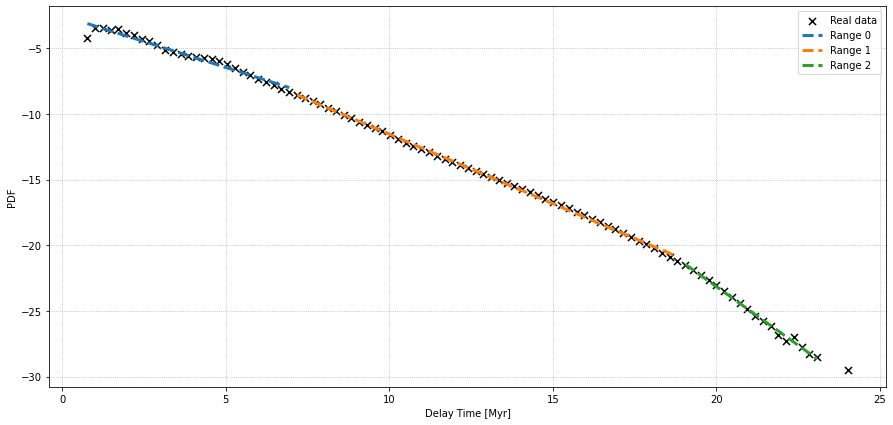

In [44]:
bin_centers, entries = plot_complete(BHBH, 'GWtime', True, 100)
fit_complete(bin_centers, entries)
fit_range(bin_centers, entries)

Using Merger Time computed

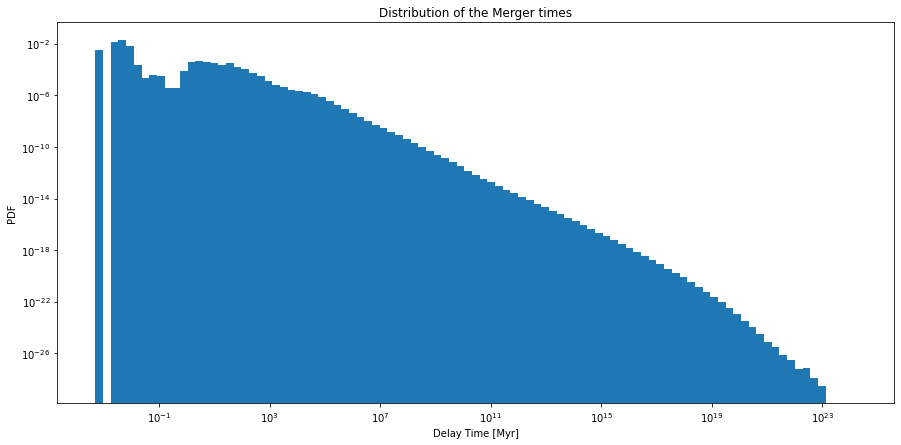

slope (95%):	 -0.988827 +/- 0.037730
intercept (95%): -2.610938 +/- 0.474821
chi2 statistic:	-28.6
p-value:       	nan

R2 = 0.9671585670605348 
R = 0.9834422032130484
Covariance matrix:
 [[ 1.        -0.9834422]
 [-0.9834422  1.       ]]





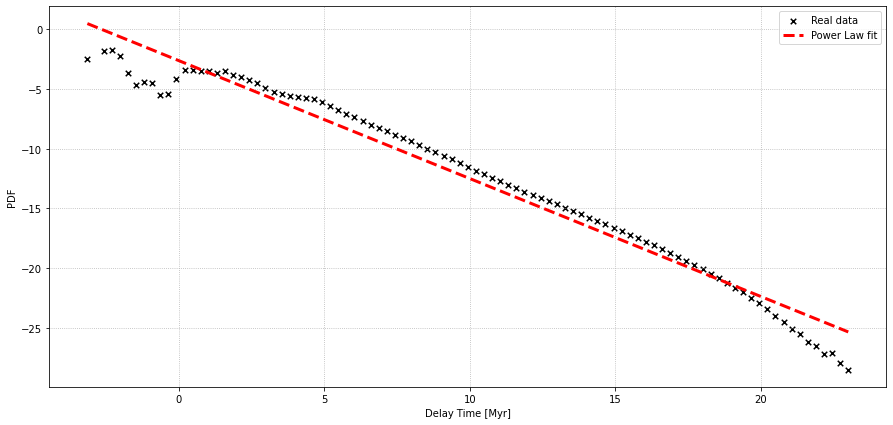

----- FIT 0 -----

slope (95%):	 -0.498528 +/- 0.099618
intercept (95%): -3.830633 +/- 0.350985
chi2 statistic:	-5.9284
p-value:       	nan

R2 = 0.7526038564735862 
R = 0.8675274384557449
Covariance matrix:
 [[ 1.         -0.86752744]
 [-0.86752744  1.        ]]



----- FIT 1 -----

slope (95%):	 -1.059294 +/- 0.009535
intercept (95%): -0.944422 +/- 0.128164
chi2 statistic:	-0.026594
p-value:       	nan

R2 = 0.9991861321385431 
R = 0.9995929832379493
Covariance matrix:
 [[ 1.         -0.99959298]
 [-0.99959298  1.        ]]



----- FIT 2 -----

slope (95%):	 -1.775700 +/- 0.065458
intercept (95%): 12.380962 +/- 1.380502
chi2 statistic:	-0.009808
p-value:       	nan

R2 = 0.9962292305689411 
R = 0.9981128345878241
Covariance matrix:
 [[ 1.         -0.99811283]
 [-0.99811283  1.        ]]





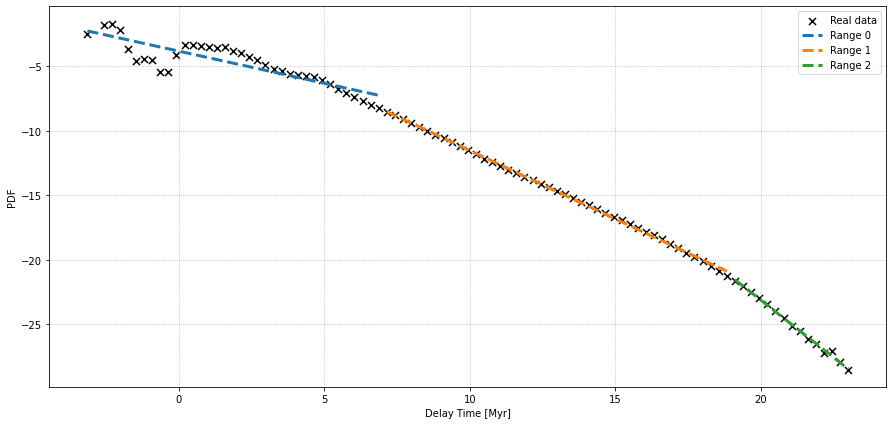

In [46]:
bin_centers, entries = plot_complete(BHBH, 'Delay_Time', False, 100)
fit_complete(bin_centers, entries)
fit_range(bin_centers, entries)

Fit of the merger time computed

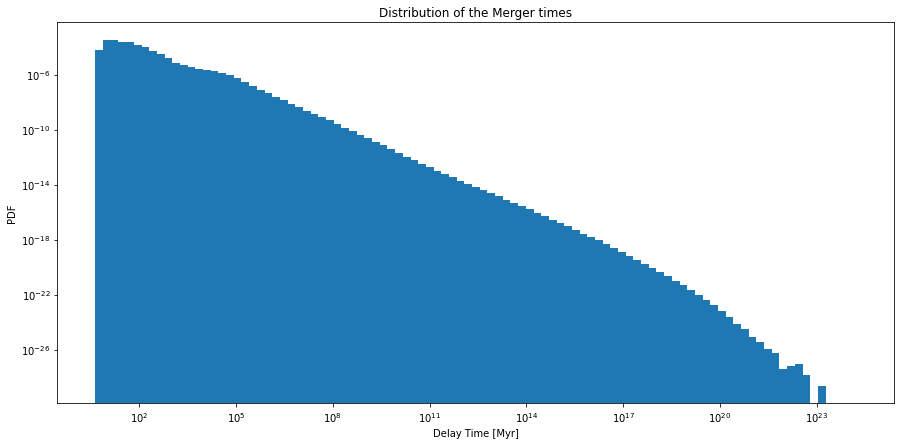

slope (95%):	 -1.098929 +/- 0.024688
intercept (95%): -0.948398 +/- 0.333501
chi2 statistic:	-5.5045
p-value:       	nan

R2 = 0.9883655775444184 
R = 0.9941657696503227
Covariance matrix:
 [[ 1.         -0.99416577]
 [-0.99416577  1.        ]]





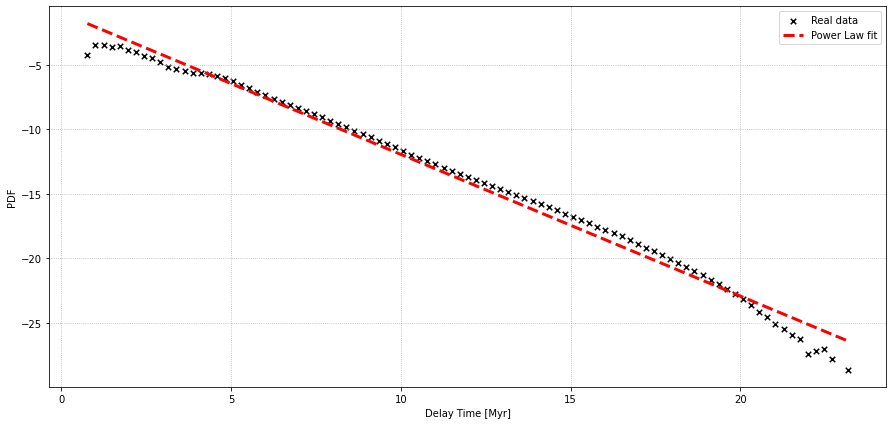

----- FIT 0 -----

slope (95%):	 -0.791319 +/- 0.062415
intercept (95%): -2.507941 +/- 0.267966
chi2 statistic:	-0.45584
p-value:       	nan

R2 = 0.9646299738887176 
R = 0.9821557788297728
Covariance matrix:
 [[ 1.         -0.98215578]
 [-0.98215578  1.        ]]



----- FIT 1 -----

slope (95%):	 -1.060123 +/- 0.009045
intercept (95%): -0.938834 +/- 0.122040
chi2 statistic:	-0.032519
p-value:       	nan

R2 = 0.9991364149632931 
R = 0.9995681142189826
Covariance matrix:
 [[ 1.         -0.99956811]
 [-0.99956811  1.        ]]



----- FIT 2 -----

slope (95%):	 -1.771887 +/- 0.105687
intercept (95%): 12.282264 +/- 2.227722
chi2 statistic:	-0.032885
p-value:       	nan

R2 = 0.9883898539671484 
R = 0.9941779790194251
Covariance matrix:
 [[ 1.         -0.99417798]
 [-0.99417798  1.        ]]





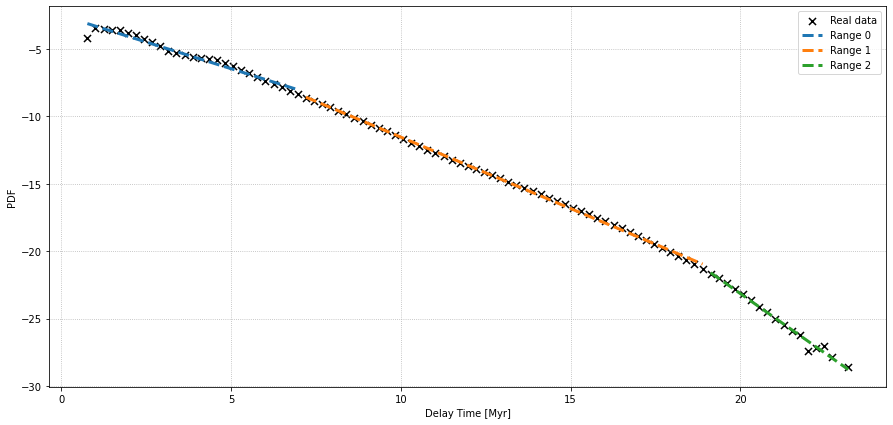

In [67]:
bin_centers, entries = plot_complete(BHBH, 'Delay_Time', True, 100)
fit_complete(bin_centers, entries)
fit_range(bin_centers, entries)

Text(0, 0.5, 'PDF')

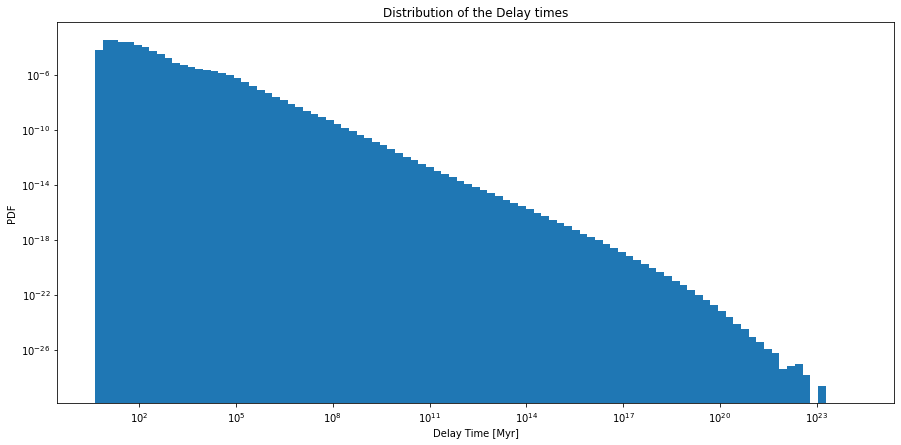

In [48]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(BHBH.Delay_Time+BHBH.BWorldtime)), np.log10(max(BHBH.Delay_Time+BHBH.BWorldtime)), 100)
entries, edges, _ = ax.hist(BHBH.Delay_Time+BHBH.BWorldtime, bins=b, density=True)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')

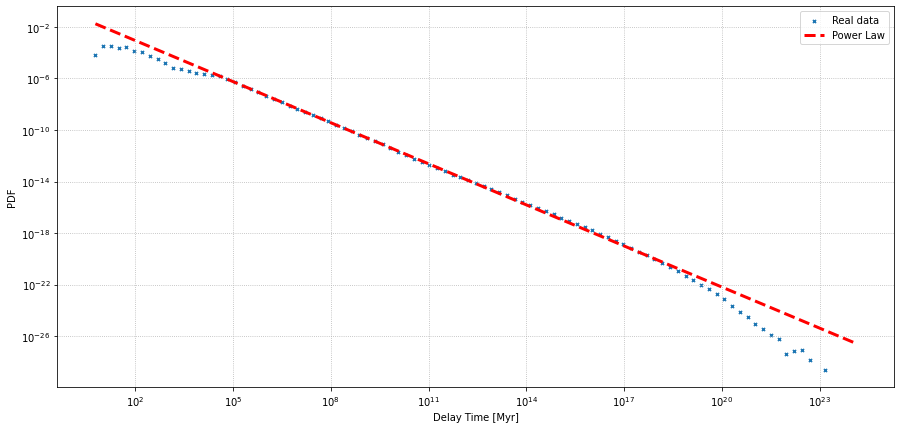

In [49]:
fig, ax = plt.subplots(figsize=(15,7))

# removing the first point from the fit
popt, pcov = curve_fit(power_law, bin_centers[np.where((bin_centers>1e9) & (bin_centers<1e19))], entries[np.where((bin_centers>1e9) & (bin_centers<1e19))], p0=(.005, 18))

ax.scatter(bin_centers, entries, s=10, marker='x', label='Real data')
ax.plot(bin_centers, power_law(bin_centers, popt[0], popt[1]), 'r--', lw=3, label='Power Law')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')

ax.grid(ls='dotted')
ax.legend(loc='upper right')

plt.show()

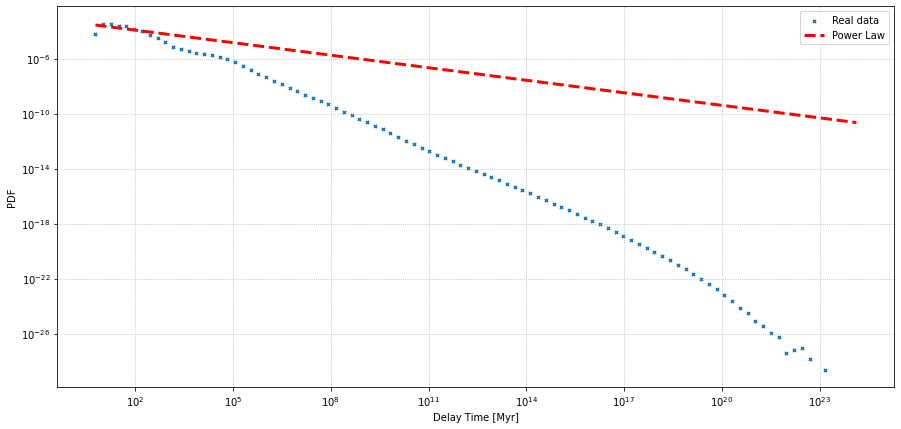

Chi2:		 0.000810080403229329 
p-value:		 1.0


In [50]:
# fit of all the points

fig, ax = plt.subplots(figsize=(15,7))

# removing the first point from the fit
popt, pcov = curve_fit(power_law, bin_centers, entries, p0=(.005, 18), method='lm')

ax.scatter(bin_centers, entries, s=10, marker='x', label='Real data')
ax.plot(bin_centers, power_law(bin_centers, popt[0], popt[1]), 'r--', lw=3, label='Power Law')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')

ax.grid(ls='dotted')
ax.legend(loc='upper right')

plt.show()

chi, pv = chisqr(power_law(bin_centers, popt[0], popt[1]), entries)
print("Chi2:\t\t", chi, "\np-value:\t\t", pv)

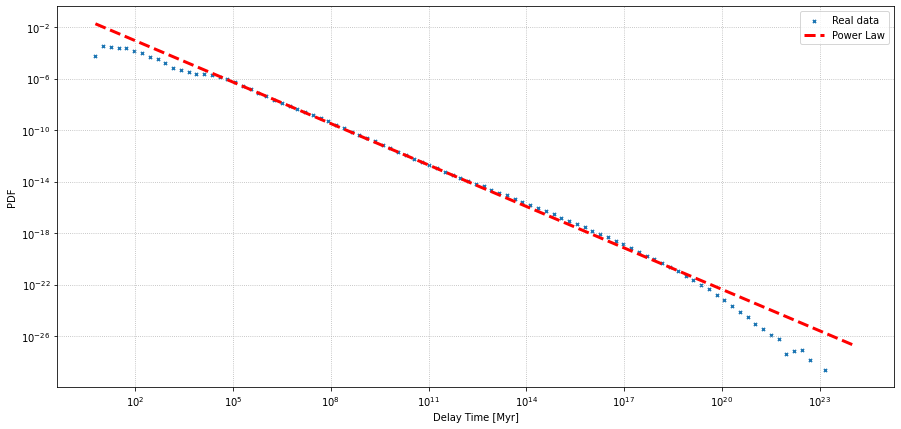

Chi2:		 0.039451997044817416 
p-value:		 1.0


In [51]:
# fit removing the initial points

xmin = 1e6

fig, ax = plt.subplots(figsize=(15,7))

# removing the first point from the fit
popt, pcov = curve_fit(power_law, bin_centers[np.where(bin_centers>xmin)], entries[np.where(bin_centers>xmin)], p0=(.005, 18))

ax.scatter(bin_centers, entries, s=10, marker='x', label='Real data')
ax.plot(bin_centers, power_law(bin_centers, popt[0], popt[1]), 'r--', lw=3, label='Power Law')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')

ax.grid(ls='dotted')
ax.legend(loc='upper right')

plt.show()

chi, pv = chisqr(power_law(bin_centers, popt[0], popt[1]), entries)
print("Chi2:\t\t", chi, "\np-value:\t\t", pv)

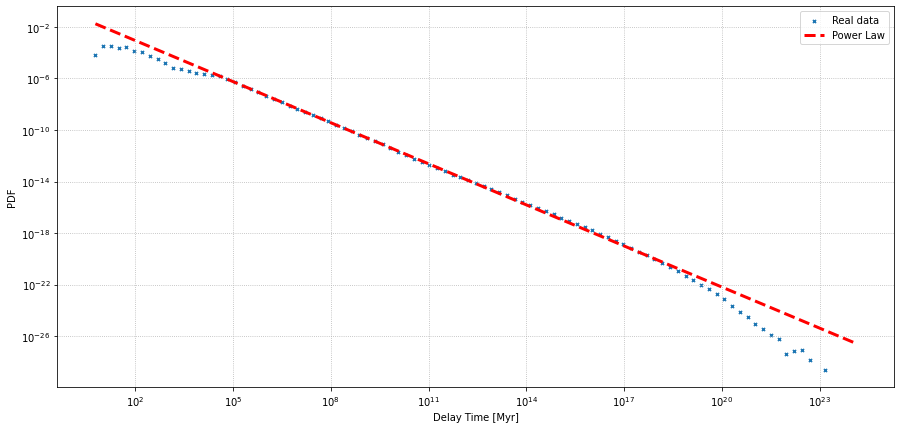

Chi2:		 0.03707385471447948 
p-value:		 1.0


In [52]:
xmin, xmax = 1e9, 1e19

fig, ax = plt.subplots(figsize=(15,7))

# removing the first point from the fit
popt, pcov = curve_fit(power_law, bin_centers[np.where((bin_centers>xmin) & (bin_centers<xmax))], entries[np.where((bin_centers>xmin) & (bin_centers<xmax))], p0=(.005, 18))

ax.scatter(bin_centers, entries, s=10, marker='x', label='Real data')
ax.plot(bin_centers, power_law(bin_centers, popt[0], popt[1]), 'r--', lw=3, label='Power Law')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')

ax.grid(ls='dotted')
ax.legend(loc='upper right')

plt.show()


chi, pv = chisqr(power_law(bin_centers, popt[0], popt[1]), entries)

print("Chi2:\t\t", chi, "\np-value:\t\t", pv)

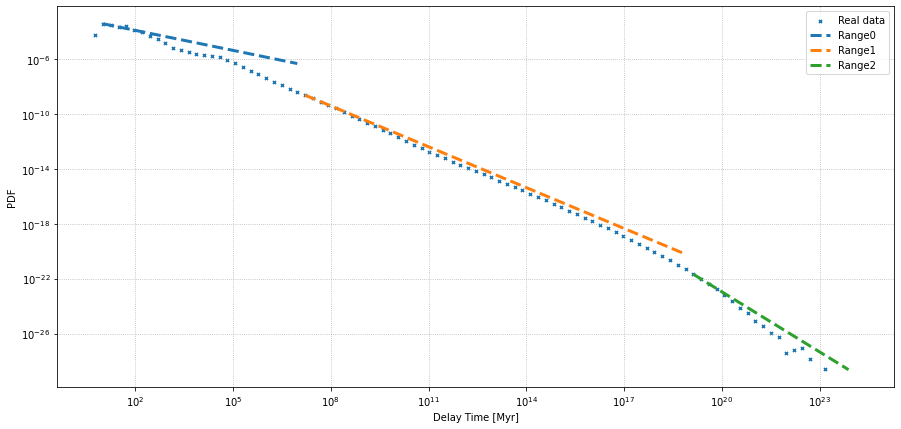

In [53]:
fig, ax = plt.subplots(figsize=(15,7))

popt, pcov = (np.empty(shape=3, dtype=object) for i in range(2))
xstep      = (min(bin_centers), 1e7, 1e19, max(bin_centers))

ax.scatter(bin_centers, entries, s=10, marker='x', label='Real data')
for i in range(len(popt)):
    popt[i], pcov[i] = curve_fit(power_law, bin_centers[np.where((bin_centers>xstep[i]) & (bin_centers<xstep[i+1]))], entries[np.where((bin_centers>xstep[i]) & (bin_centers<xstep[i+1]))], p0=(.005, 18))
    ax.plot(bin_centers[np.where((bin_centers>xstep[i]) & (bin_centers<xstep[i+1]))], power_law(bin_centers[np.where((bin_centers>xstep[i]) & (bin_centers<xstep[i+1]))], popt[i][0], popt[i][1]), '--', lw=3, label='Range'+str(i))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')

ax.grid(ls='dotted')
ax.legend(loc='upper right')

plt.show()


#### ROOT fit

In [14]:
c = ROOT.TCanvas()

xstep = (0, 1e5, 1e19, 1e30)

root_hist = np.zeros(nbins+1,dtype=float)
root_hist[1:-1] = entries
h = ROOT.TH1D('Delay TIme','hist',nbins-1,edges)
h.SetContent(root_hist)
h.SetTitle("Fit of the delay times distribution;Delay Time [Myr];PDF")

6.170670144709989e-09 57
1.0825737095982436e-10 1.0
 FCN=6.17067e-09 FROM HESSE     STATUS=NOT POSDEF     30 CALLS          60 TOTAL
                     EDM=1.90579e-34    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a           -1.06658e+00   5.14486e-17   1.01852e+00   2.85307e-07
   2  b           -8.82426e-01   7.01363e-10   5.58328e+00   2.78362e-08


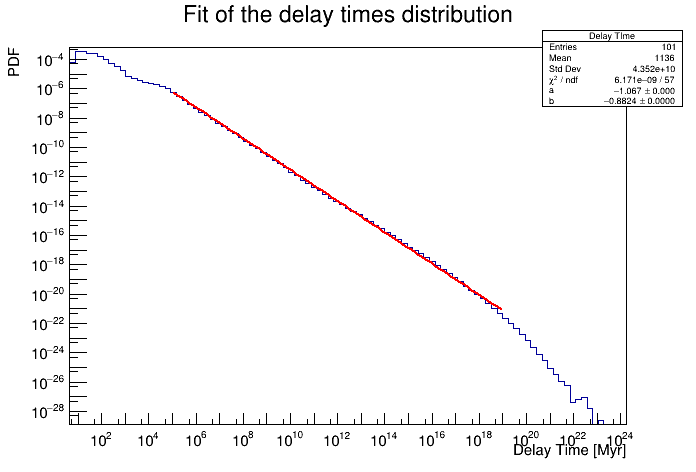

In [15]:
# Fit histogram with root #
pl = ROOT.TF1( 'PowerLaw', 'x ** [0] * 10 ** [1]',xstep[1],xstep[2])
pl.SetParameters(-1.06327767, -.9284432)
pl.SetParNames( "a", "b" );
h.Fit(pl,"RS")

# Get Root Fit and Goodness of Fit Parameters #
a,   b = pl.GetParameter(0), pl.GetParameter(1)
ea, eb = pl.GetParError( 0), pl.GetParError( 1)
ndf,chi2,prob = pl.GetNDF(),pl.GetChisquare(),pl.GetProb()

print(chi2, ndf)
print(chi2/ndf,prob)

c.Draw()
h.Draw()
ROOT.gPad.SetLogy()
ROOT.gPad.SetLogx()

ROOT.gStyle.SetOptFit()

 FCN=0.00090476 FROM MIGRAD    STATUS=CONVERGED      45 CALLS          46 TOTAL
                     EDM=5.80811e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   6.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a            4.33773e-01   1.06128e+01   4.04605e-02  -1.99620e-04
   2  b           -3.45440e+00   2.62340e+01   1.19618e-01   8.32589e-05
 FCN=6.17067e-09 FROM HESSE     STATUS=OK             30 CALLS          60 TOTAL
                     EDM=1.39028e-19    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  a            1.06658e+00   1.38959e-09   1.01852e+00  -2.85307e-07
   2  b           -8.82426e-01   1.89433e-02   5.58328e+00   2.78362e-08
 FCN=6.48752e-24 FROM HESSE     STATUS=NOT POSDEF     30 CALLS          87 TOTAL
     

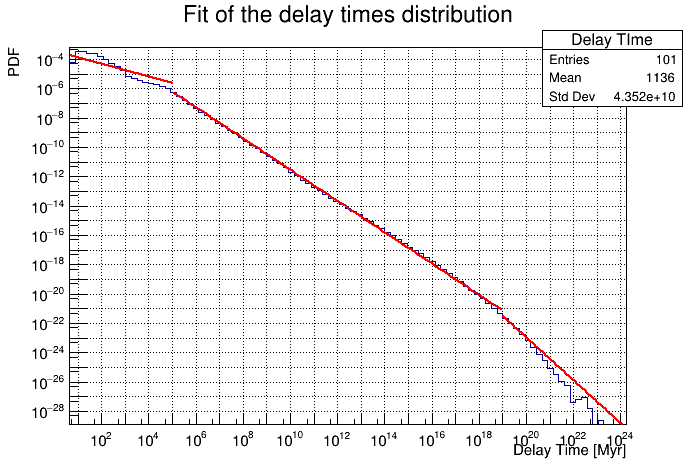

In [16]:
c.Draw()
c.SetGrid()
h.Draw()


# Fit histogram with root #
pl = [ROOT.TF1( 'PowerLaw', 'x^(-[0]) * 10^[1]',xstep[i],xstep[i+1]) for i in range(3)]

pl[0].SetParameters(0.30381919, -3.3028521 )
pl[1].SetParameters(1.06327767, -0.9284432 )
pl[2].SetParameters(1.66173166,  6.28556267)
for i in range(3):
    pl[i].SetParNames( "a", "b" )
    h.Fit(pl[i],"RS")
    pl[i].Draw("same")

# Get Root Fit and Goodness of Fit Parameters #
a,   b        = [pl[i].GetParameter(0) for i in range(3)], [pl[i].GetParameter(1) for i in range(3)]
ea, eb        = [pl[i].GetParError(0)  for i in range(3)], [pl[i].GetParError(1)  for i in range(3)]
ndf,chi2,prob = [pl[i].GetNDF()        for i in range(3)], [pl[i].GetChisquare()  for i in range(3)], [pl[i].GetProb()  for i in range(3)]

#print(chi2, ndf)
#print(chi2/ndf,prob)

ROOT.gPad.SetLogy()
ROOT.gPad.SetLogx()

ROOT.gStyle.SetOptFit(False)

In [17]:
c = ROOT.TCanvas()

xstep      = (min(bin_centers), 1e7, 1e19, max(bin_centers))

nbins = len(bin_centers[np.where(entries!=0)])

root_hist = np.zeros(nbins+2,dtype=float)
root_hist[1:-1] = np.log10(entries[np.where(entries!=0)])
h = ROOT.TH1D('Delay TIme','hist',nbins-1,np.log10(edges[np.where(entries!=0)]))
h.SetContent(root_hist)
h.SetTitle("Fit of the delay times distribution;Delay Time [Myr];PDF")

Warning in <TROOT::Append>: Replacing existing TH1: Delay TIme (Potential memory leak).


p-values:	 [1.0, 1.0, 0.9999999999999999]

****************************************
Minimizer is Linear / Migrad
Chi2                      =     0.144022
NDf                       =           24
a                         =     -2.35219   +/-   0.993176    
b                         =    -0.821869   +/-   0.254317    

****************************************
Minimizer is Linear / Migrad
Chi2                      =    0.0322839
NDf                       =           48
a                         =    -0.985596   +/-   1.94229     
b                         =      -1.0578   +/-   0.154029    

****************************************
Minimizer is Linear / Migrad
Chi2                      =    0.0350154
NDf                       =           14
a                         =      12.2671   +/-   23.2945     
b                         =      -1.7723   +/-   1.11757     


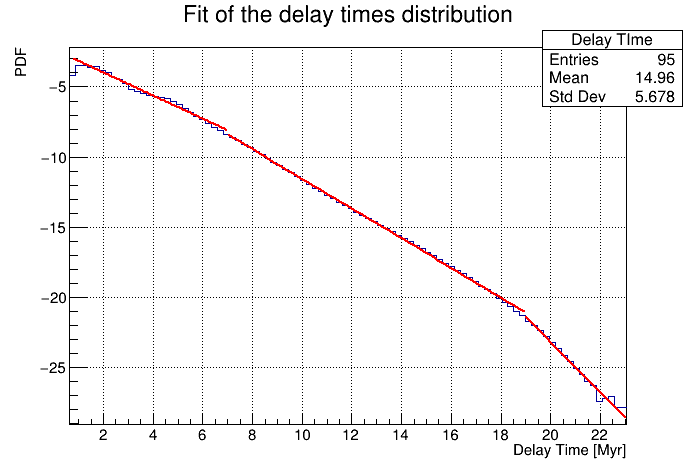

In [21]:
c.Draw()
c.SetGrid()
h.Draw()

# Fit histogram with root #
pl = [ROOT.TF1( 'Lin', 'pol1',np.log10(xstep[i]),np.log10(xstep[i+1])) for i in range(3)]

for i in range(3):
    pl[i].SetParNames( "a", "b" )
    h.Fit(pl[i],"RS")
    pl[i].Draw("same")

# Get Root Fit and Goodness of Fit Parameters #
a,   b        = [pl[i].GetParameter(0) for i in range(3)], [pl[i].GetParameter(1) for i in range(3)]
ea, eb        = [pl[i].GetParError(0)  for i in range(3)], [pl[i].GetParError(1)  for i in range(3)]
ndf,chi2,prob = [pl[i].GetNDF()        for i in range(3)], [pl[i].GetChisquare()  for i in range(3)], [pl[i].GetProb()  for i in range(3)]

#print(chi2, ndf)
#print(chi2/ndf,prob)

#ROOT.gPad.SetLogy()
#ROOT.gPad.SetLogx()

ROOT.gStyle.SetOptFit(False)

print("p-values:\t", prob)

0.03228385747919826 48
0.0006725803641499636 1.0

****************************************
Minimizer is Linear / Migrad
Chi2                      =    0.0322839
NDf                       =           48
a                         =    -0.985596   +/-   1.94229     
b                         =      -1.0578   +/-   0.154029    


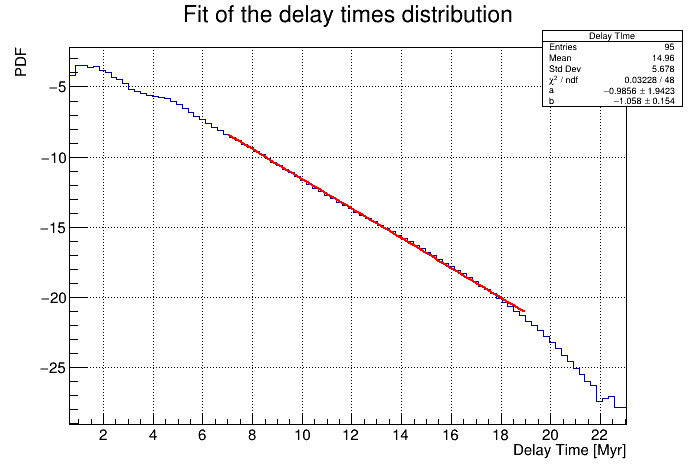

In [68]:
c.Draw()
c.SetGrid()
h.Draw()

# Fit histogram with root #
pl = ROOT.TF1( 'Lin', 'pol1',np.log10(xstep[1]),np.log10(xstep[2]))

pl.SetParNames( "a", "b" )
h.Fit(pl,"RS")
pl.Draw("same")

# Get Root Fit and Goodness of Fit Parameters #
a,   b        = pl.GetParameter(0), pl.GetParameter(1)
ea, eb        = pl.GetParError(0) , pl.GetParError(1)
ndf,chi2,prob = pl.GetNDF()       , pl.GetChisquare(), pl.GetProb()

print(chi2, ndf)
print(chi2/ndf,prob)

#ROOT.gPad.SetLogy()
#ROOT.gPad.SetLogx()

ROOT.gStyle.SetOptFit(True)

3.1139922778176445 90
0.03459991419797383 1.0

****************************************
Minimizer is Linear / Migrad
Chi2                      =      3.11399
NDf                       =           90
a                         =     -1.44581   +/-   0.554164    
b                         =     -1.05122   +/-   0.0551674   


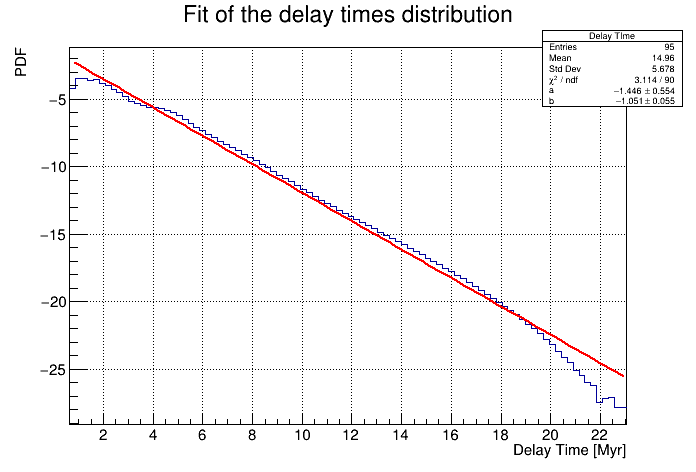

In [67]:
c.Draw()
c.SetGrid()
h.Draw()

# Fit histogram with root #
pl = ROOT.TF1( 'Lin', 'pol1',np.log10(xstep[0]),np.log10(xstep[3]))

pl.SetParNames( "a", "b" )
h.Fit(pl,"RS")
pl.Draw("same")

# Get Root Fit and Goodness of Fit Parameters #
a,   b        = pl.GetParameter(0), pl.GetParameter(1)
ea, eb        = pl.GetParError(0) , pl.GetParError(1)
ndf,chi2,prob = pl.GetNDF()       , pl.GetChisquare(), pl.GetProb()

print(chi2, ndf)
print(chi2/ndf,prob)

#ROOT.gPad.SetLogy()
#ROOT.gPad.SetLogx()

ROOT.gStyle.SetOptFit(True)

### Divide data in values of Z and alpha

In [54]:
# select unique values of Z and alpha
Z        = np.sort(BHBH.Z.unique())
alpha    = np.sort(BHBH.alpha.unique())

# create dict to store dataframes with unique
# values of Z and alpha
Z_df     = {elem : pd.DataFrame for elem in     Z}
alpha_df = {elem : pd.DataFrame for elem in alpha}

# fill dict's entry
for key in Z_df.keys():
    Z_df[key] = BHBH[:][BHBH.Z == key]

for key in alpha_df.keys():
    alpha_df[key] = BHBH[:][BHBH.alpha == key]

In [57]:
Z_df.keys()

dict_keys([0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.0139999999999999, 0.017, 0.02, 0.03])

Distribution computed merger time for different values of Z

<function matplotlib.pyplot.show(close=None, block=None)>

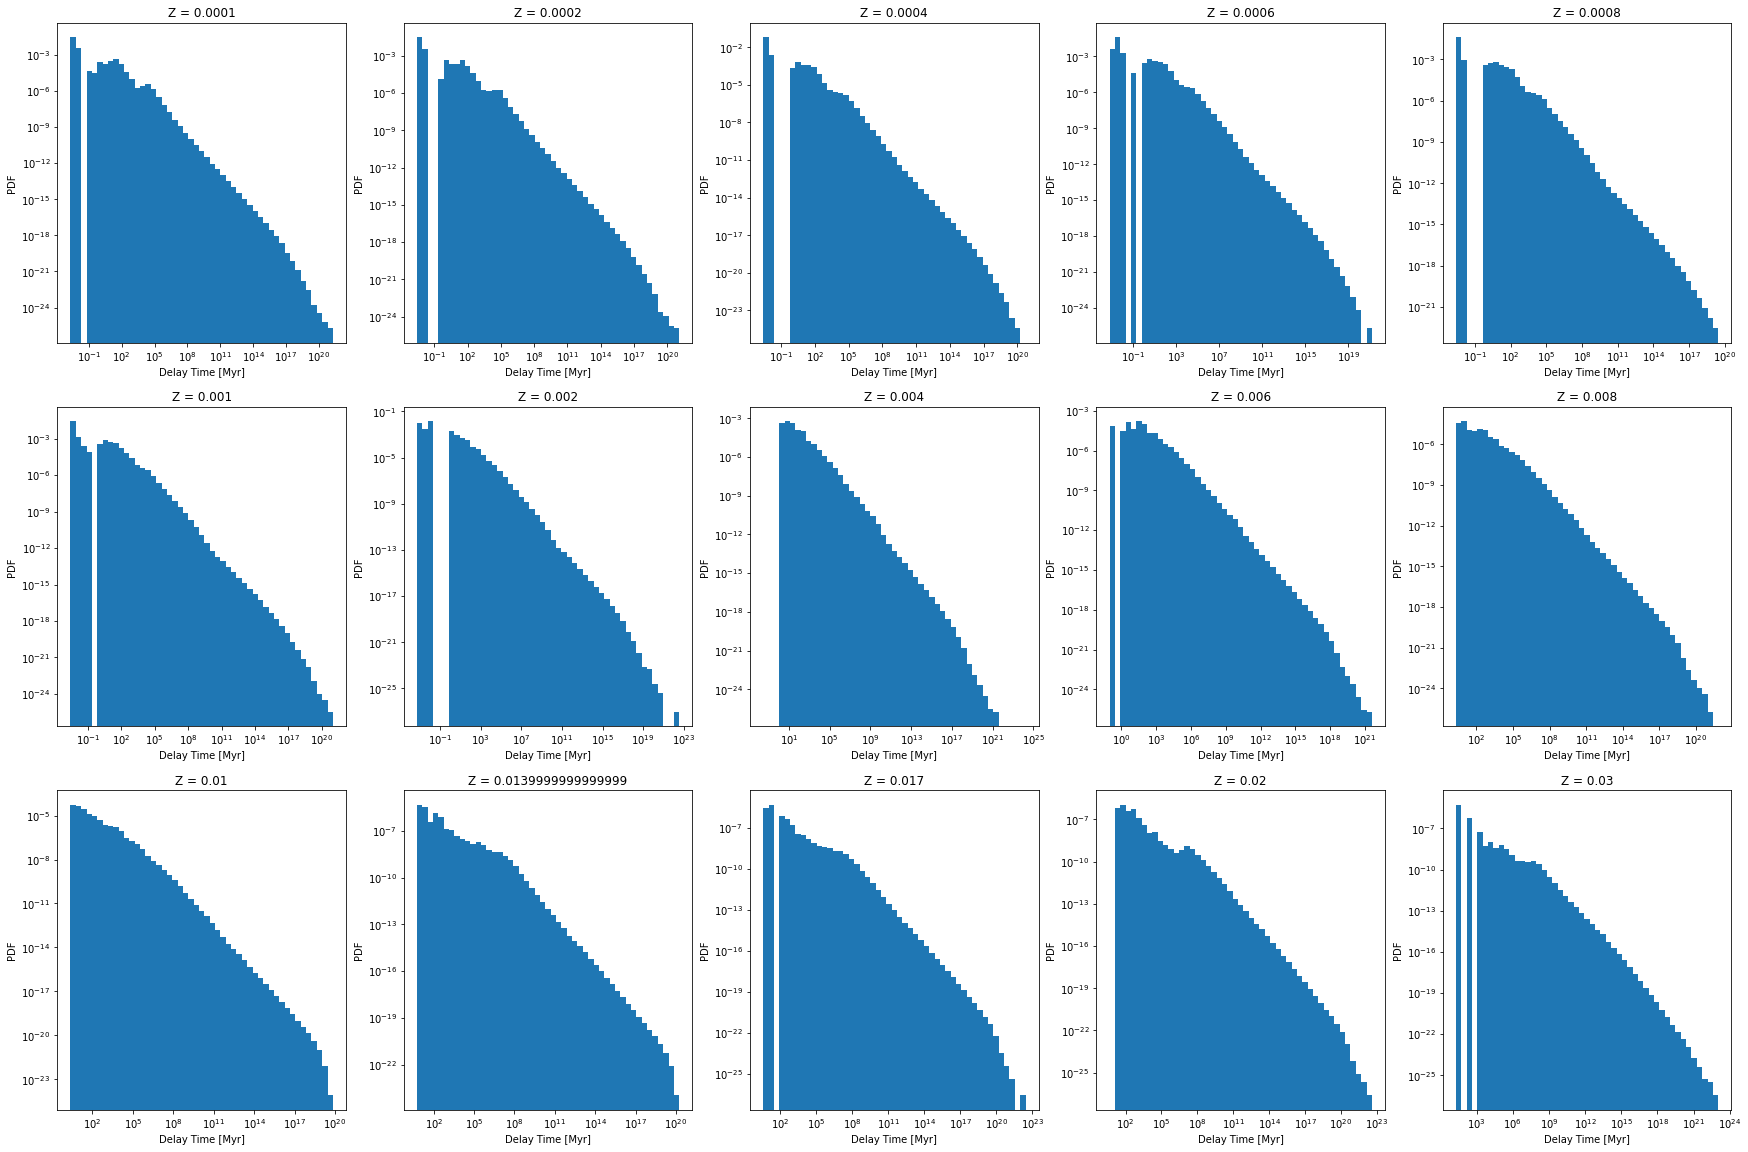

In [23]:
popt, pcov, bin_centers, entries = (np.empty(shape=(3,5), dtype=object) for i in range(4))

fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    #b                         = np.histogram_bin_edges(Z_df[key][(Z_df[key].Delay_Time<1e18)].Delay_Time, bins='rice')
    b                         = np.logspace(np.log10(min(Z_df[key].Delay_Time)), np.log10(max(Z_df[key].Delay_Time)), 50)
    entries[x,y], edges, _    = ax[x,y].hist(            Z_df[key].Delay_Time,   bins=b, density=True                 )

    # calculate bin centers
    bin_centers[x,y]          = 0.5 * (edges[:-1] + edges[1:])
    popt[x,y], pcov[x,y]      = curve_fit(power_law, bin_centers[x,y][np.where((bin_centers[x,y]>1e9) & (bin_centers[x,y]<1e19))], entries[x,y][np.where((bin_centers[x,y]>1e9) & (bin_centers[x,y]<1e19))], p0=(.005, 18))
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('PDF')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

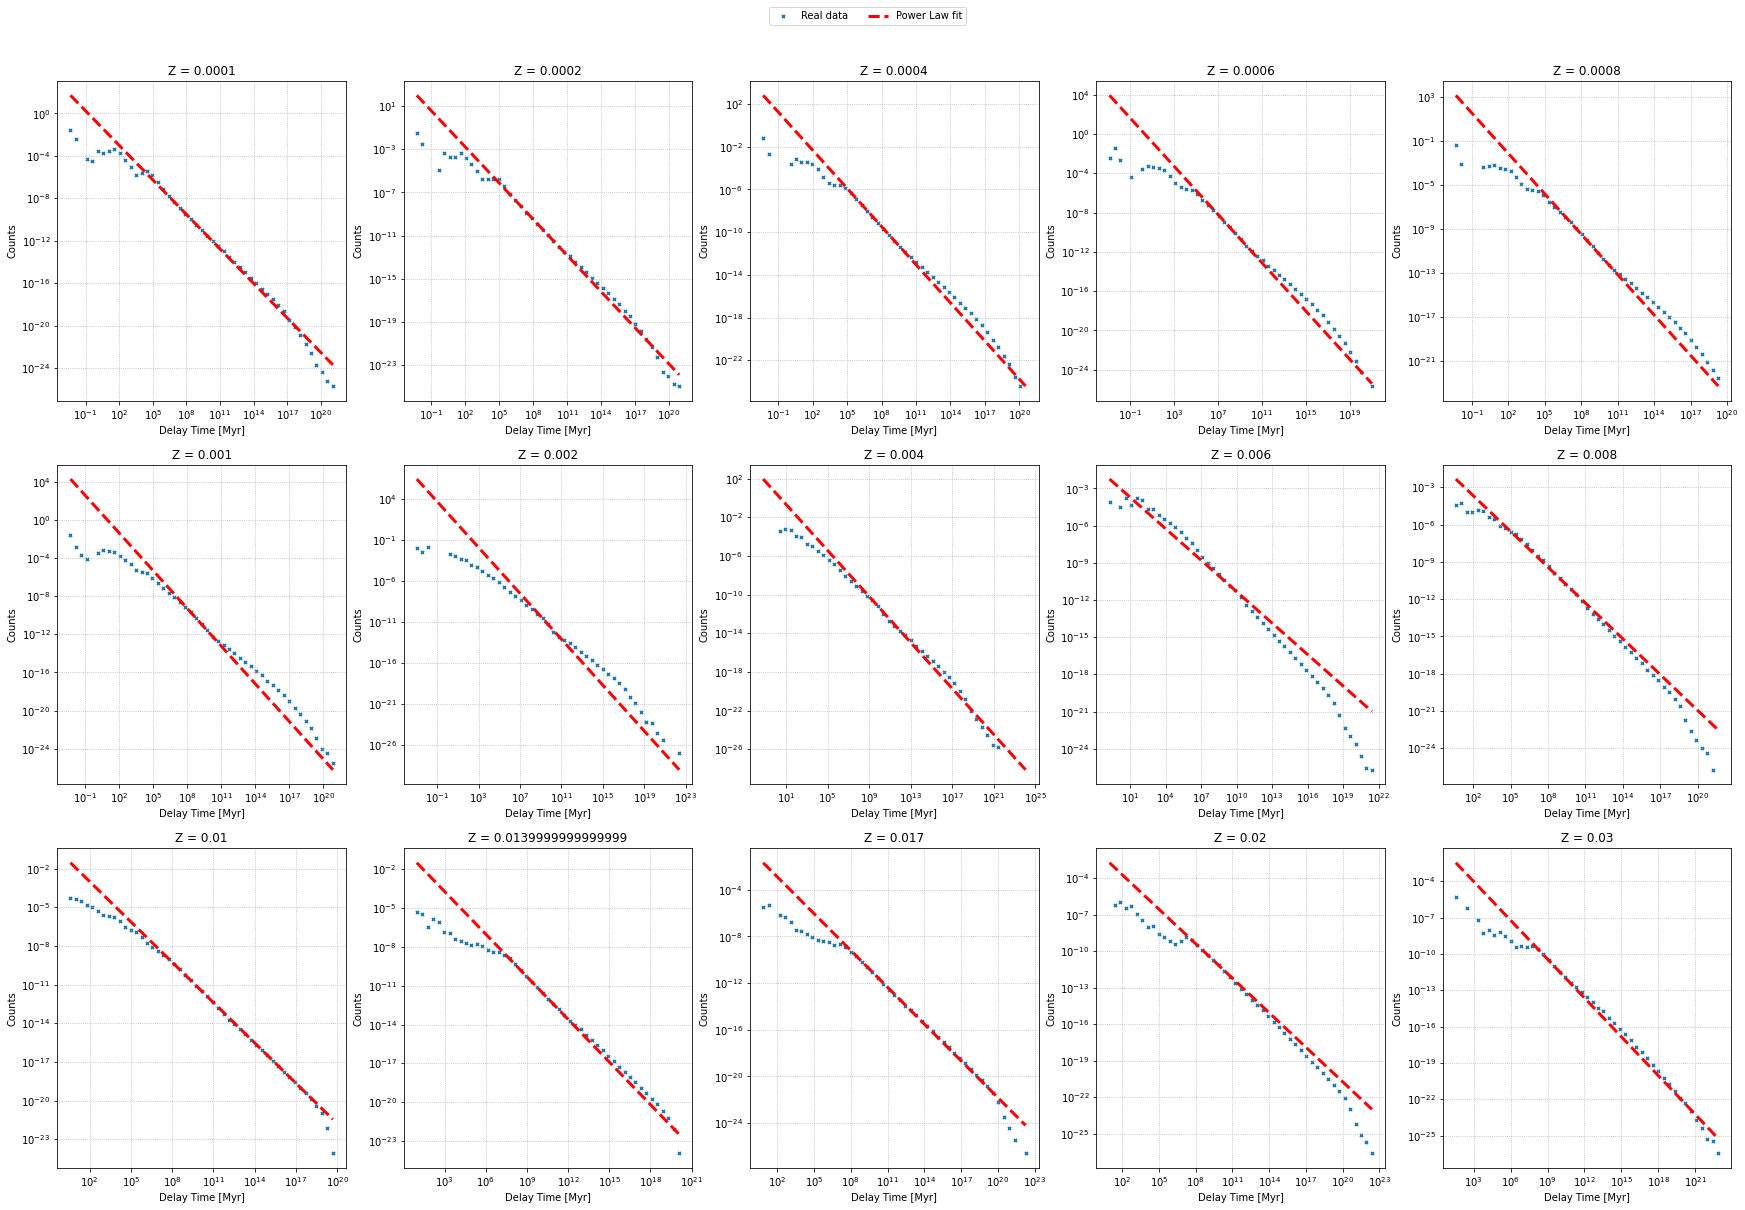

In [48]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(bin_centers[x,y], entries[x,y], s=10, marker='x')
    ax[x,y].plot(bin_centers[x,y], power_law(bin_centers[x,y], popt[x,y][0], popt[x,y][1]), 'r--', lw=3)

    ax[x,y].grid(ls='dotted')

    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('PDF')

    y += 1
    if y == 5:
        x +=1
        y = 0

labels = ['Real data', 'Power Law fit']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.show

/home/ubuntu/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ubuntu/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ubuntu/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


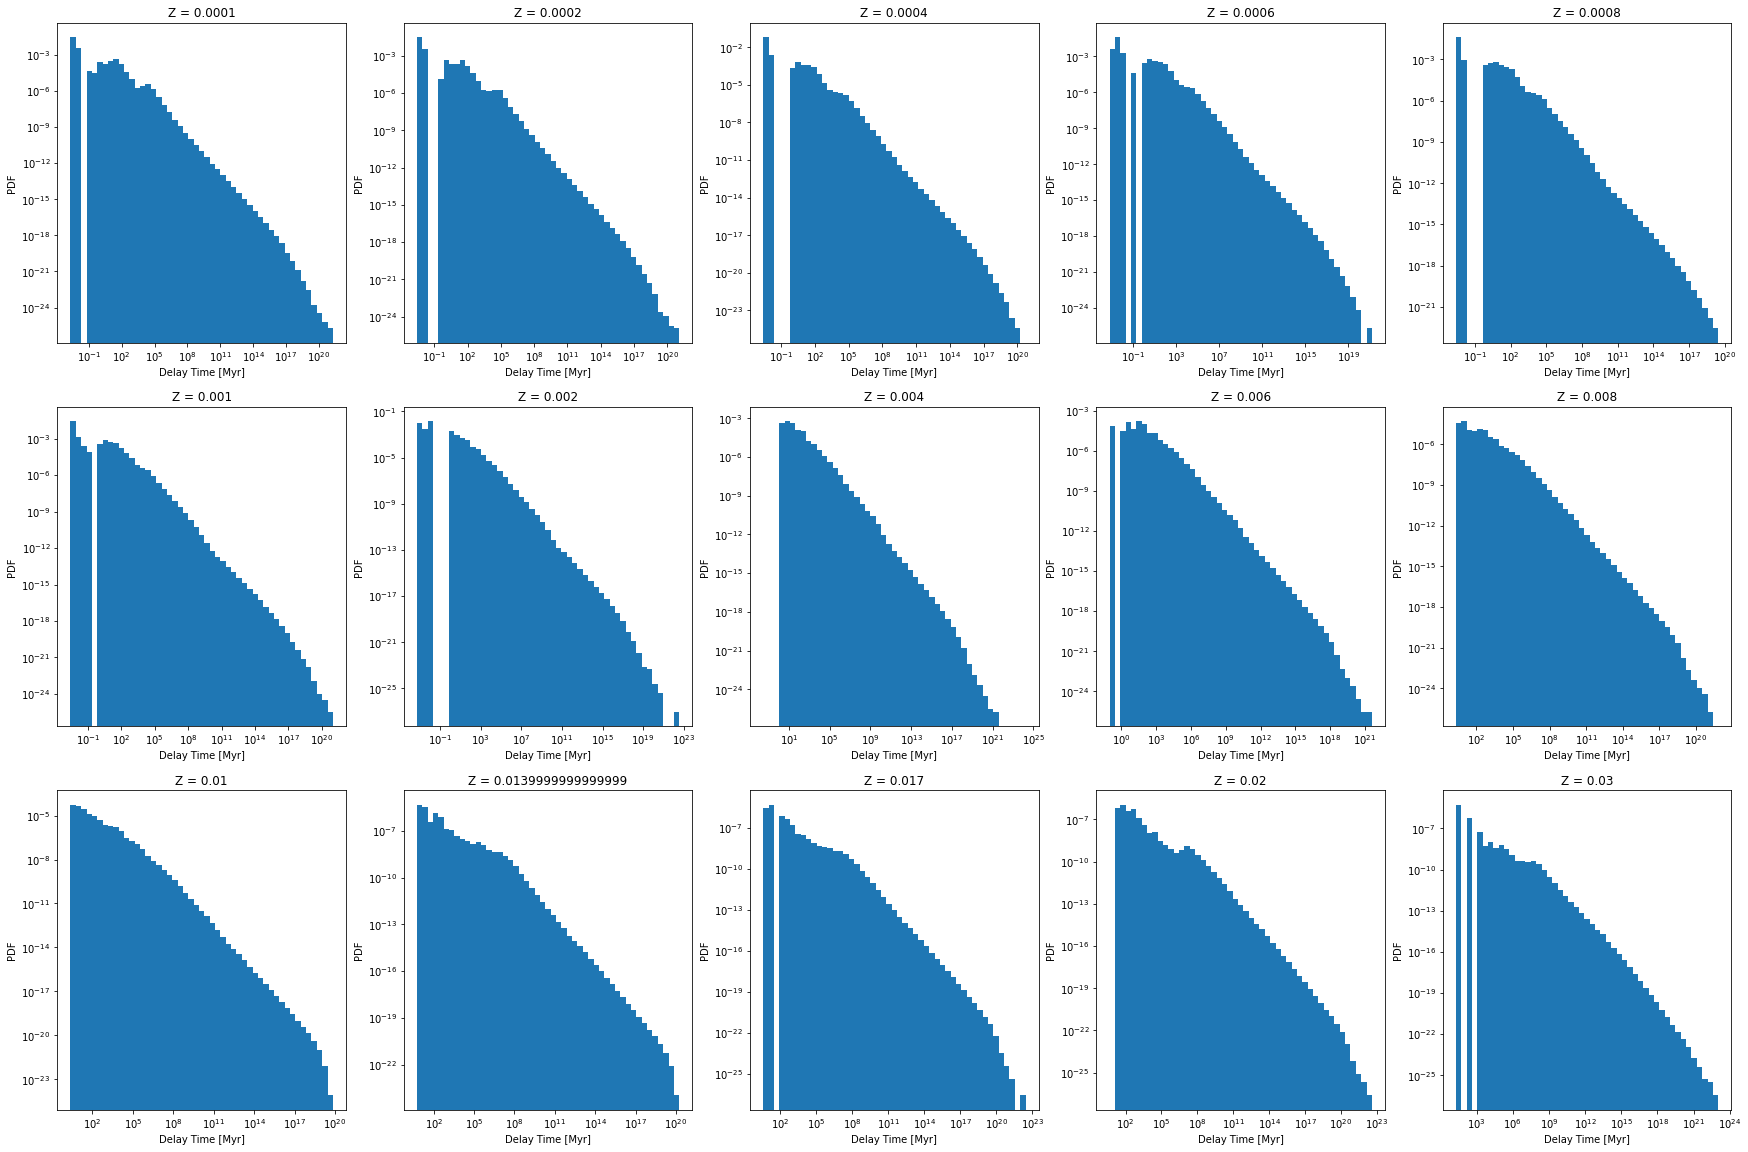

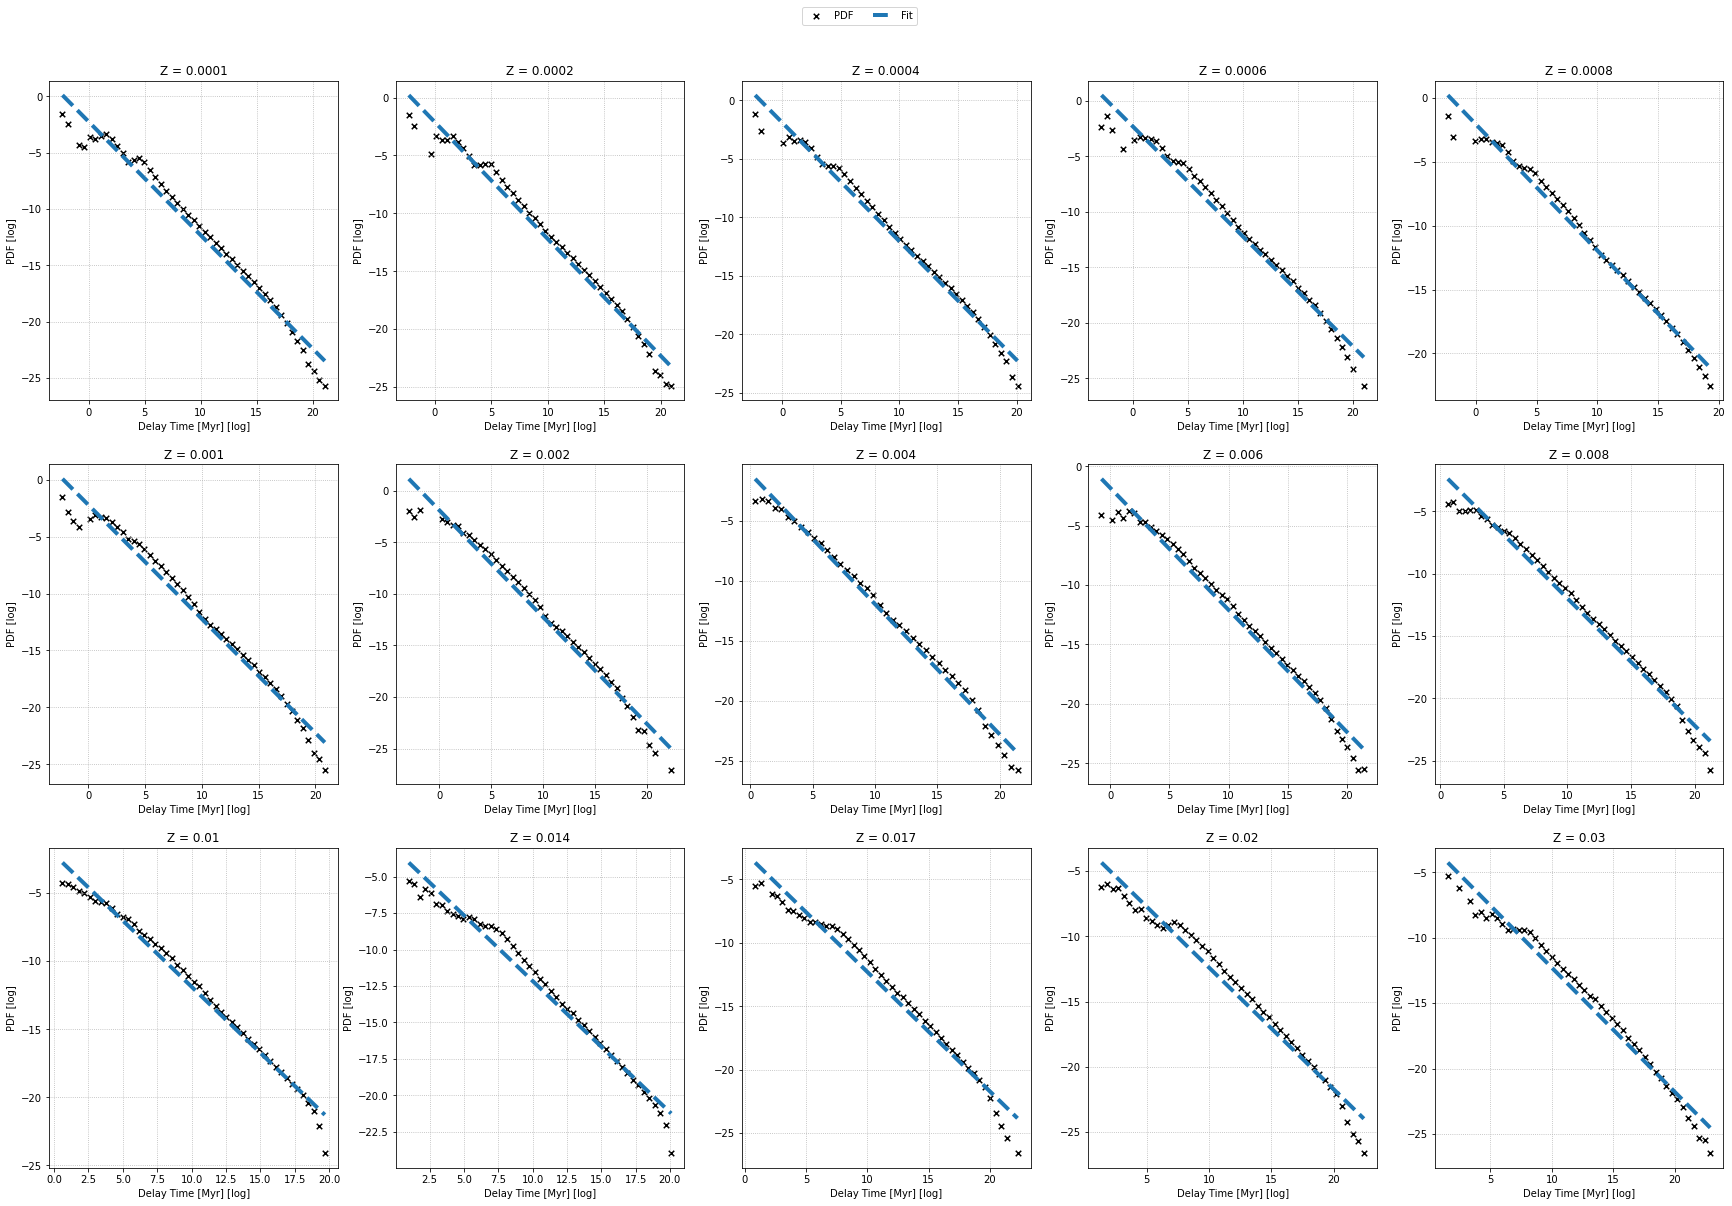

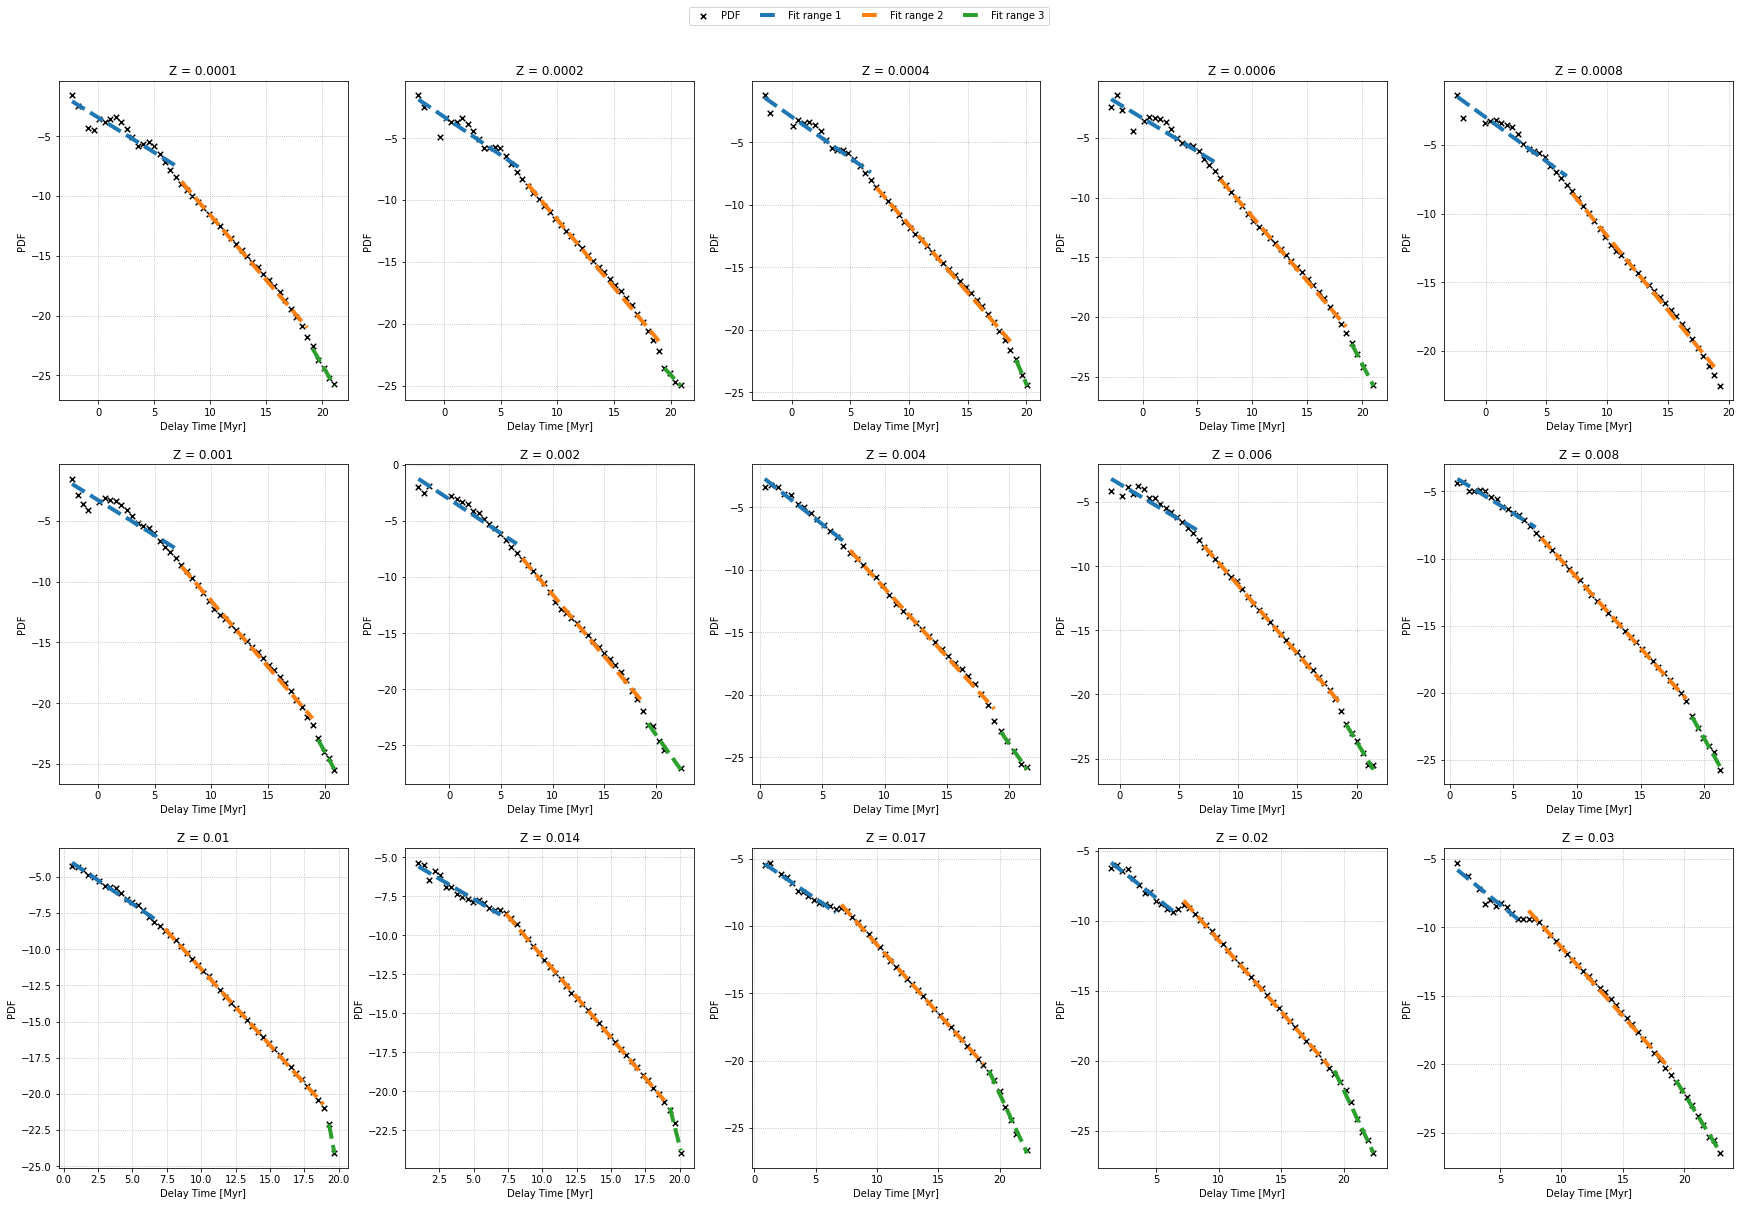

In [73]:
bin_centers, entries = Z_plot_figure(Z_df, 'Delay_Time', False, 50)
Z_fit_complete(bin_centers, entries)
Z_fit_range(bin_centers, entries)

/home/ubuntu/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ubuntu/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/ubuntu/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


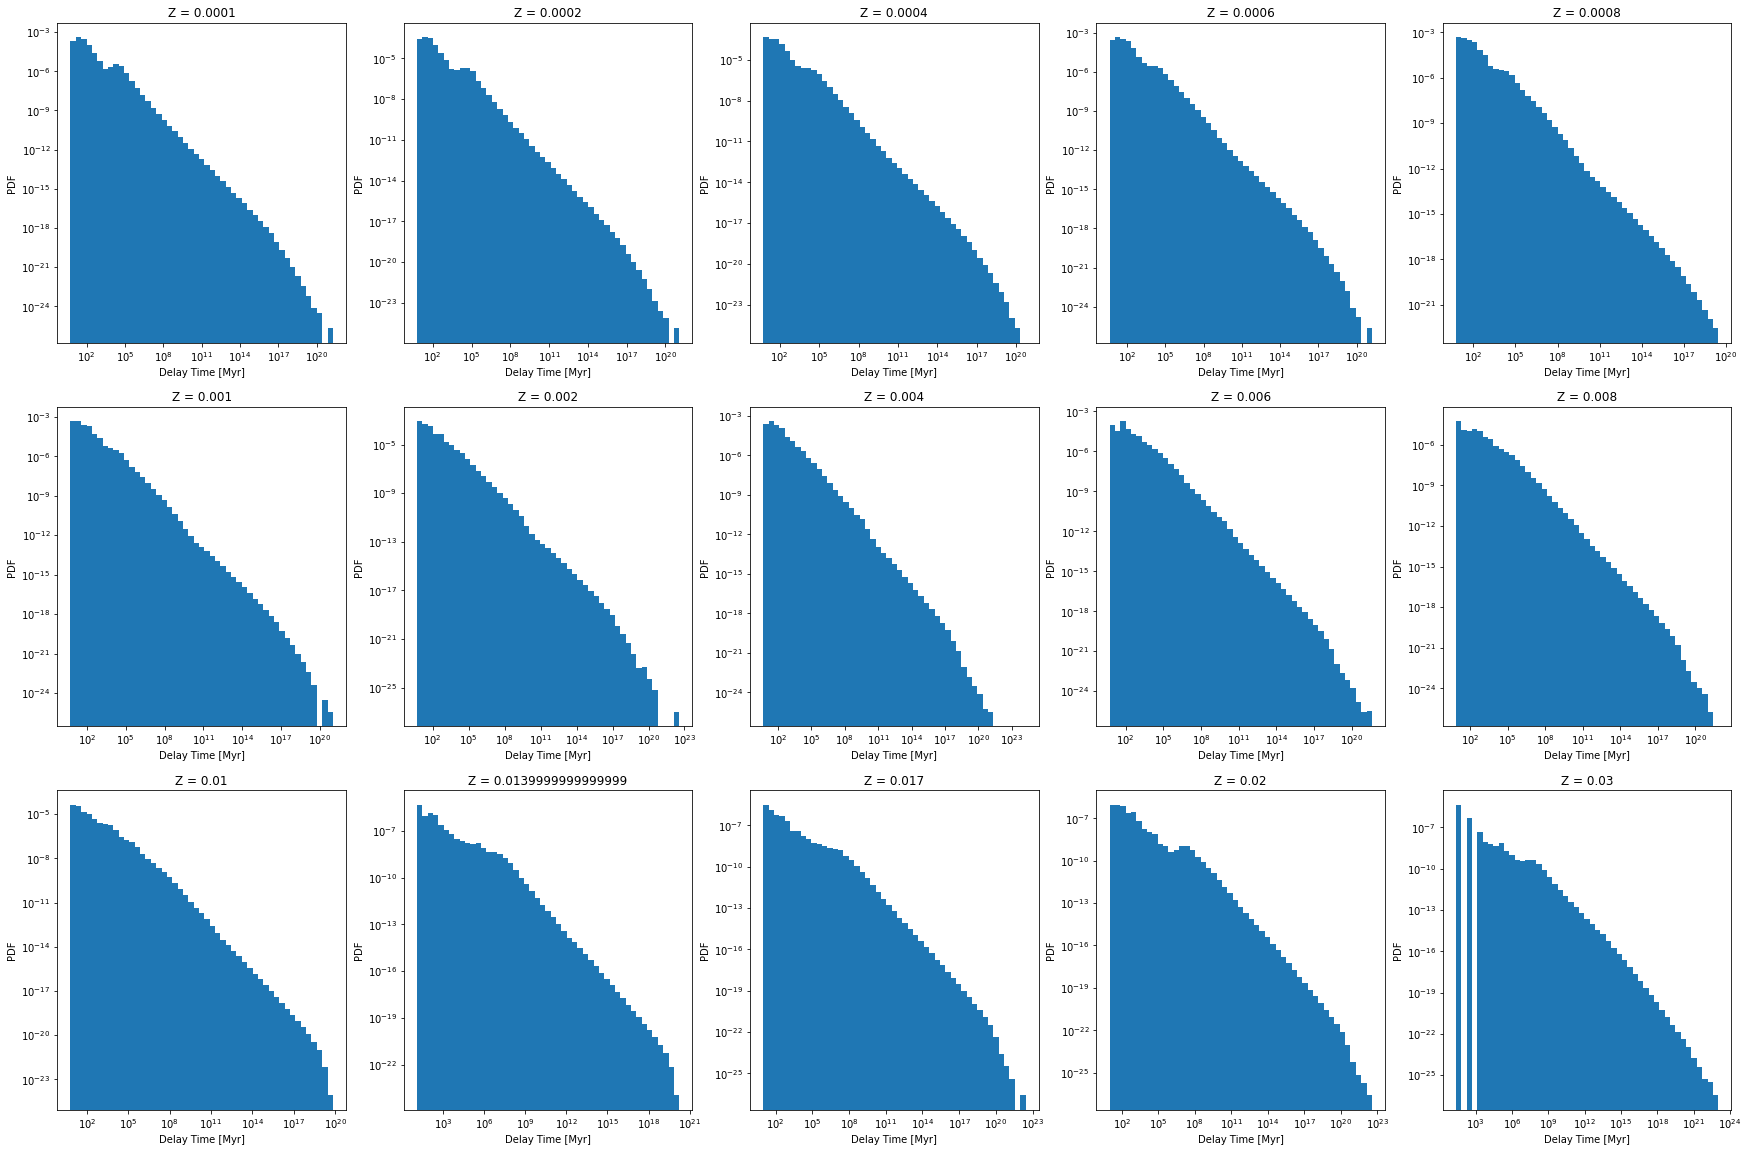

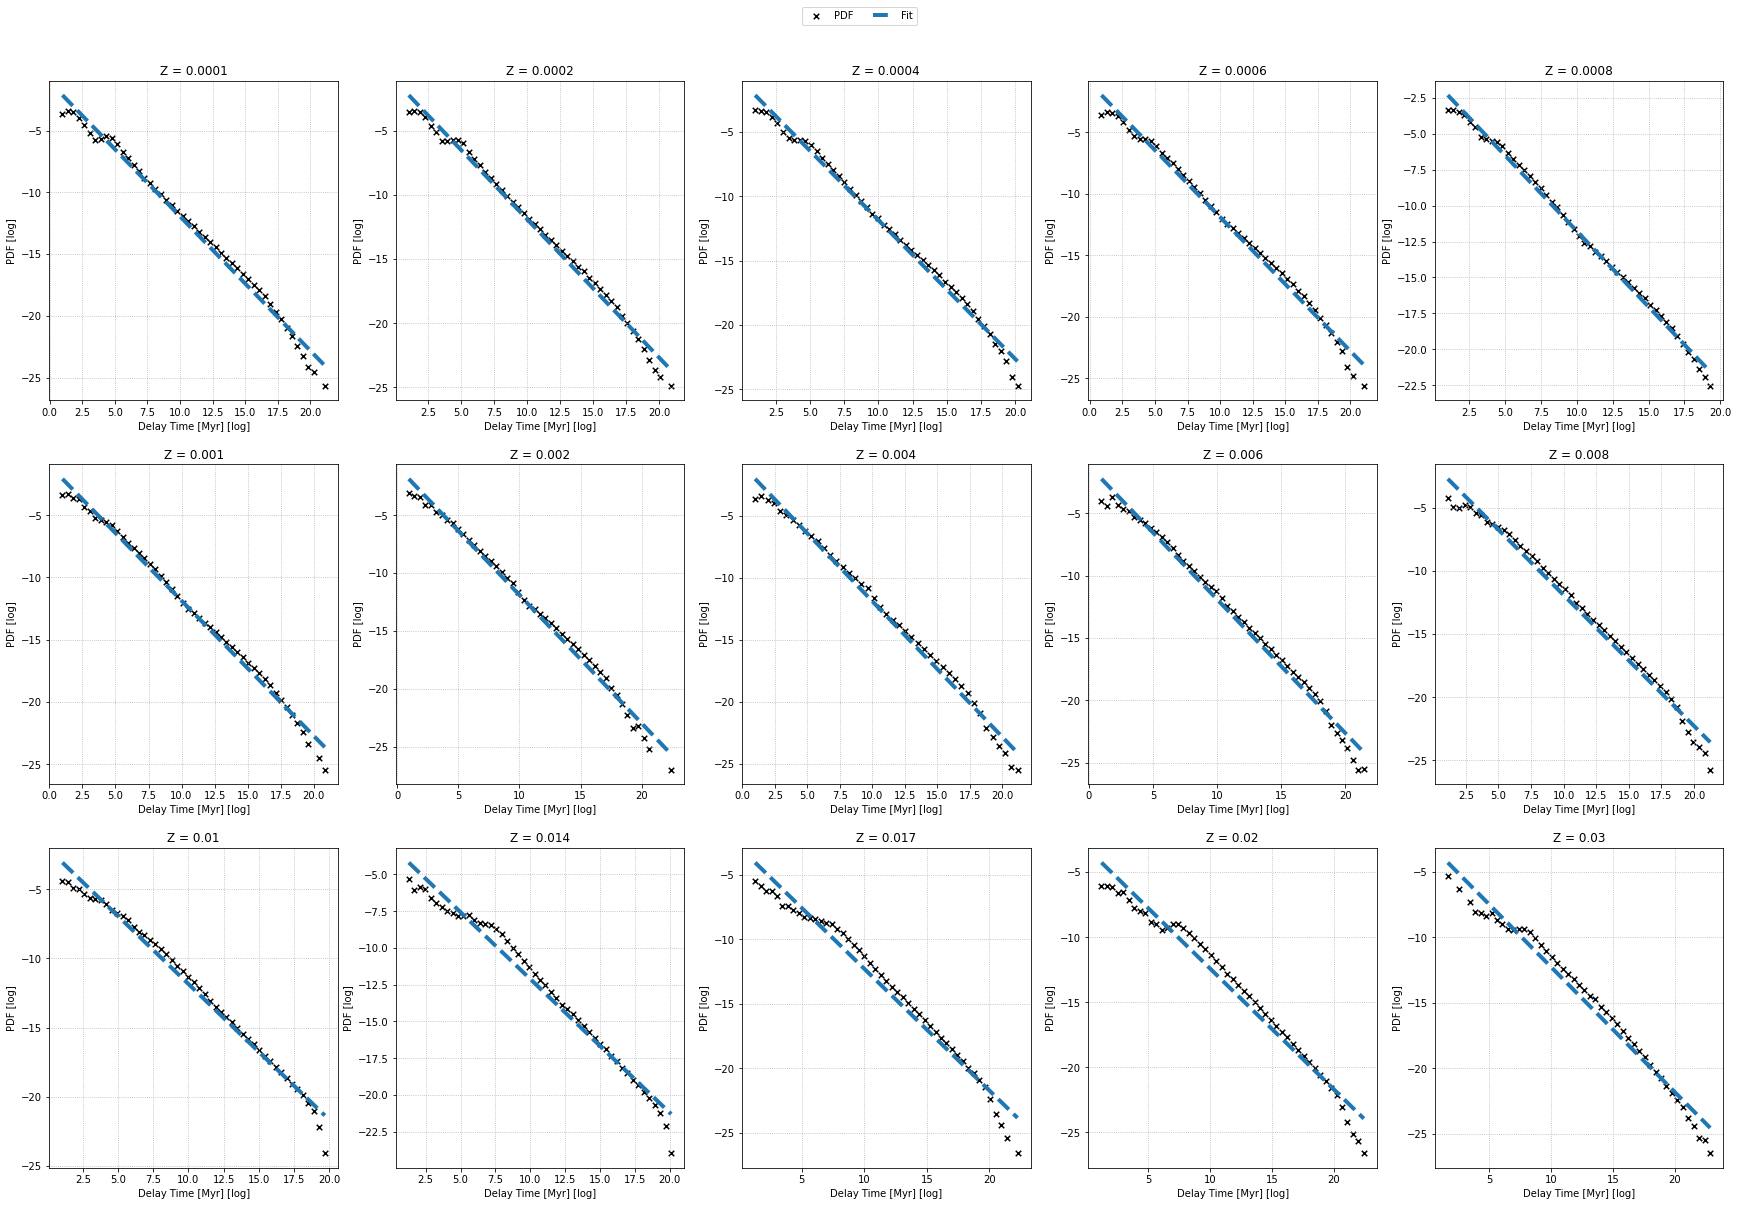

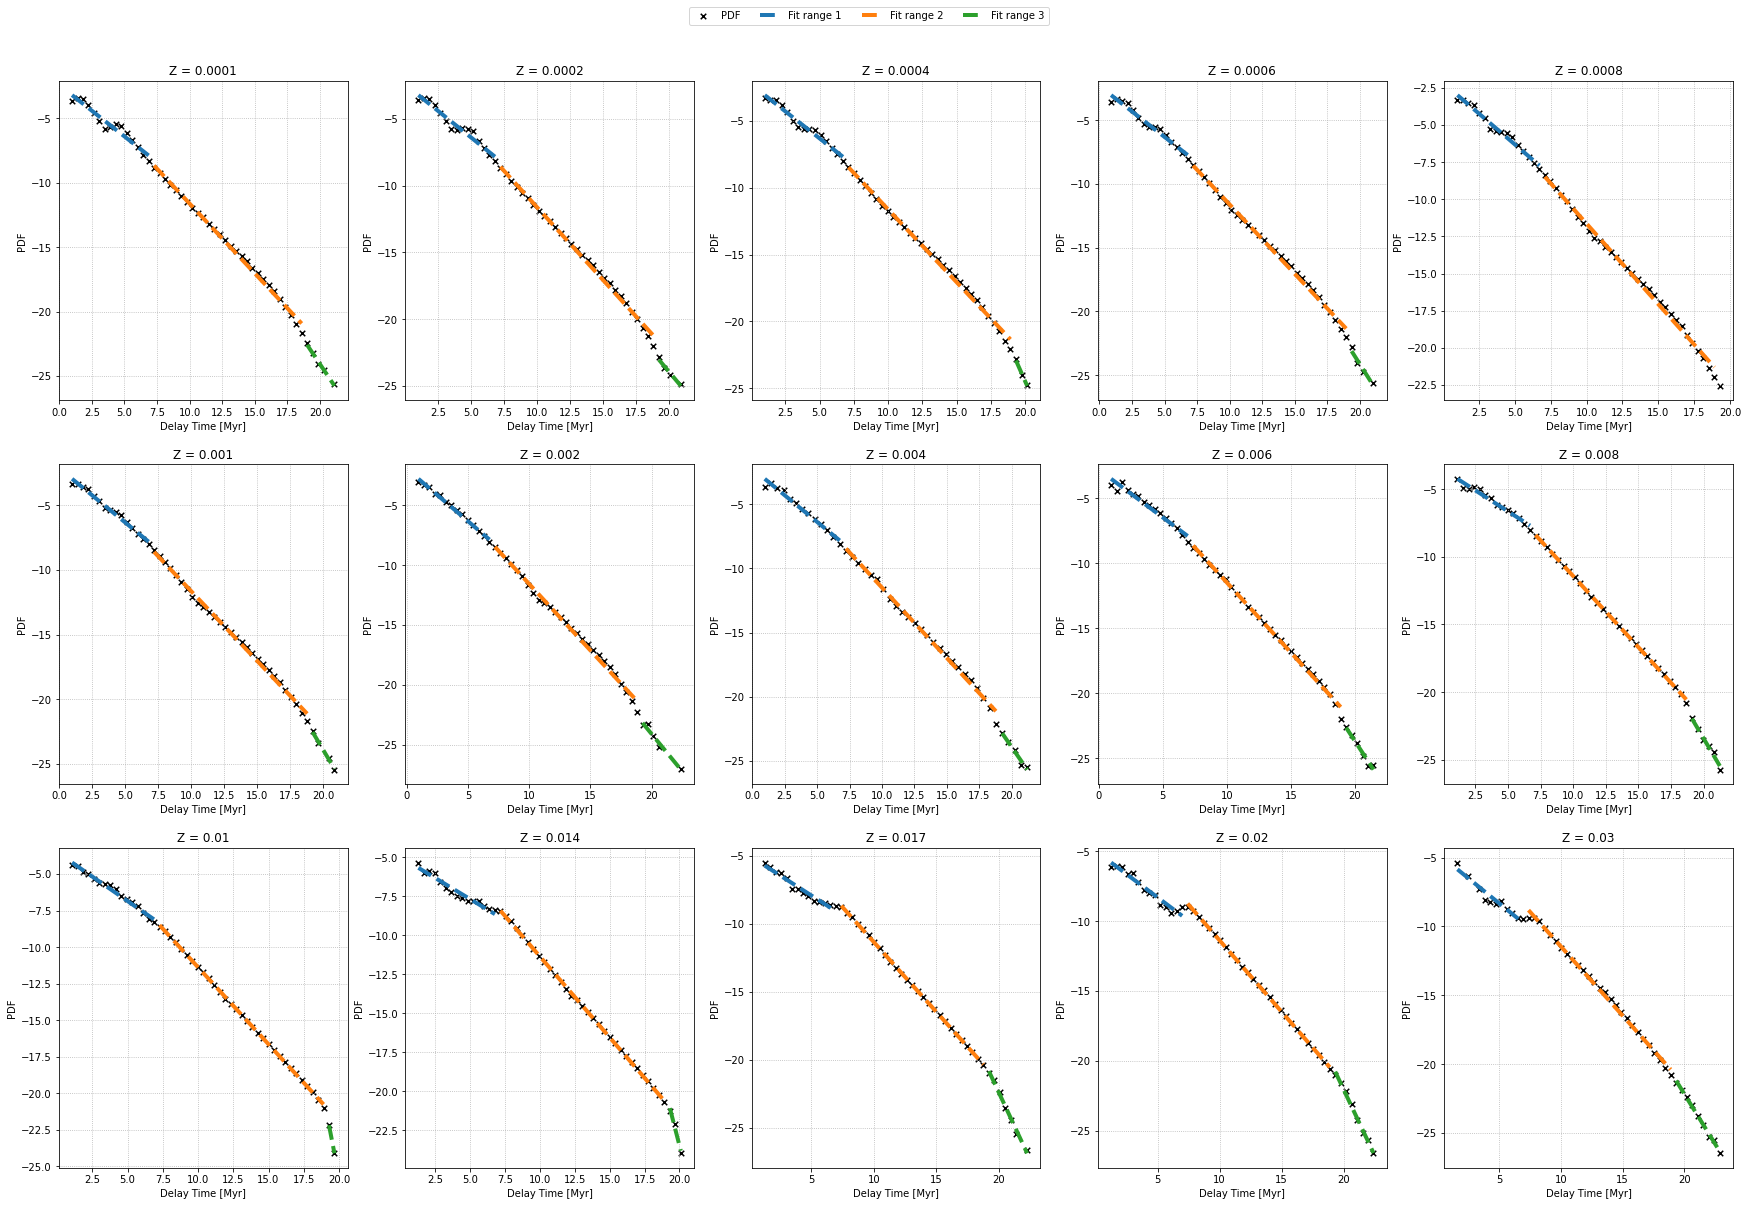

In [80]:
bin_centers, entries = Z_plot_figure(Z_df, 'Delay_Time', True, 50)
Z_fit_complete(bin_centers, entries)
Z_fit_range(bin_centers, entries)

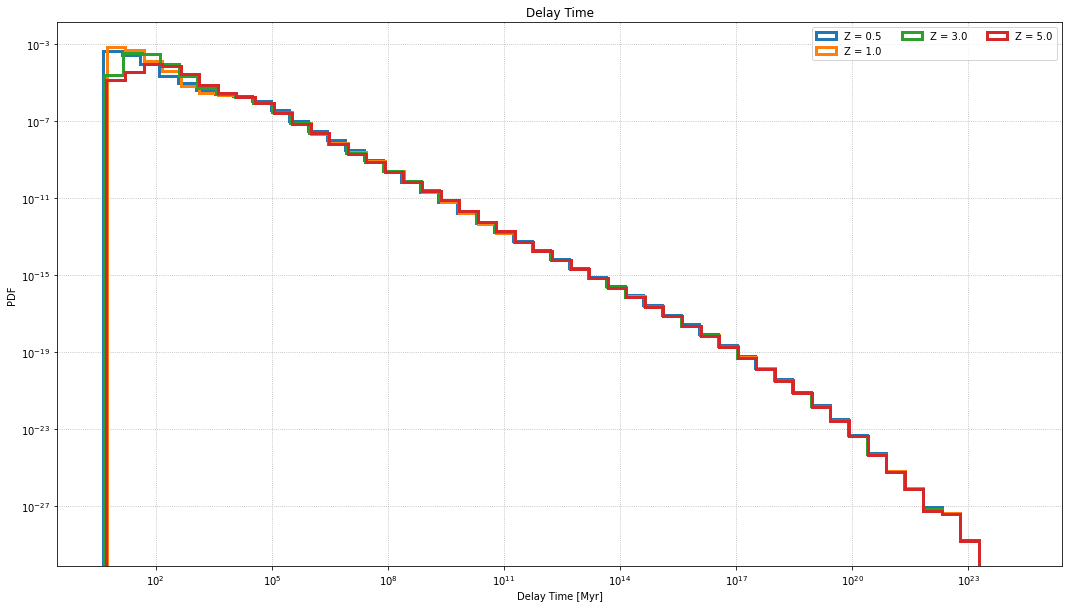

In [87]:
plot_all(alpha_df, 'Delay_Time', True, 50)

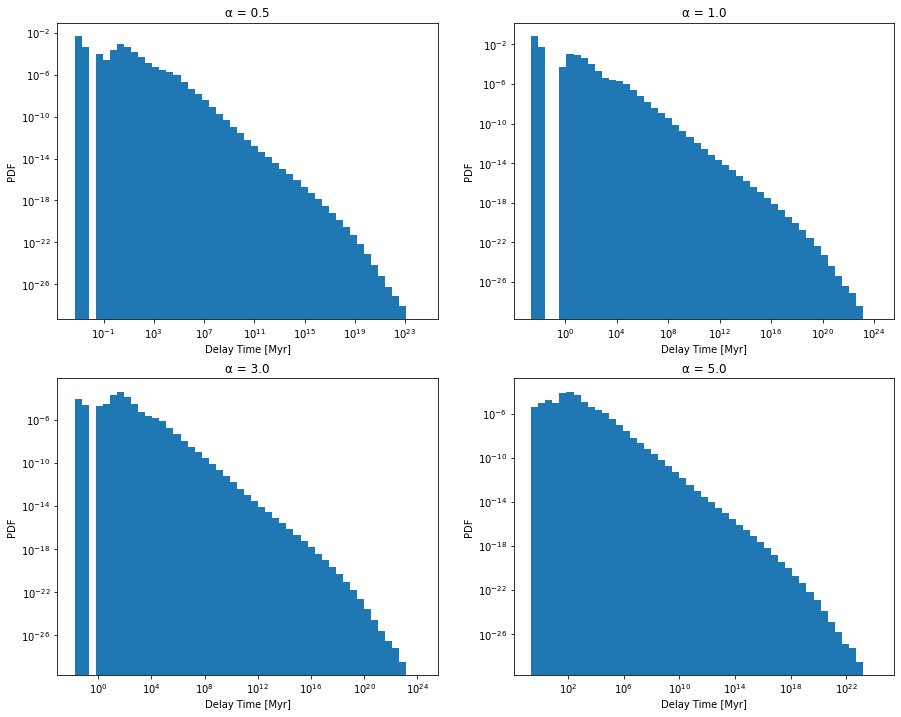

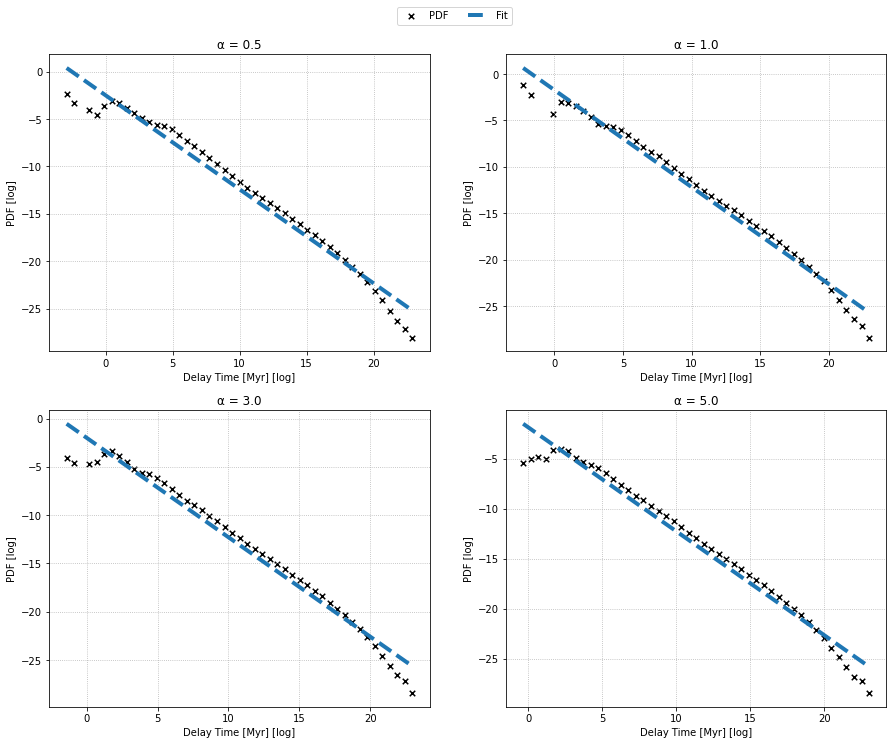

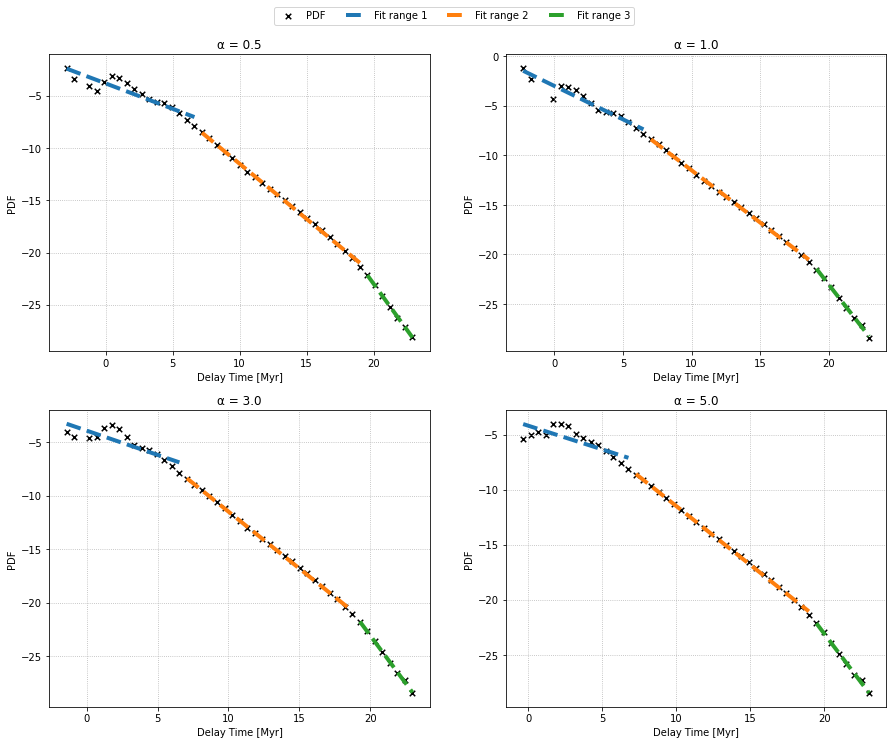

In [91]:
bin_centers, entries = alpha_plot_figure(alpha_df, 'Delay_Time', False, 50)
alpha_fit_complete(bin_centers, entries)
alpha_fit_range(bin_centers, entries)

Distribution tabulated delay time for different values of Z.

Distribution computed delay time for different values of alpha

<function matplotlib.pyplot.show(close=None, block=None)>

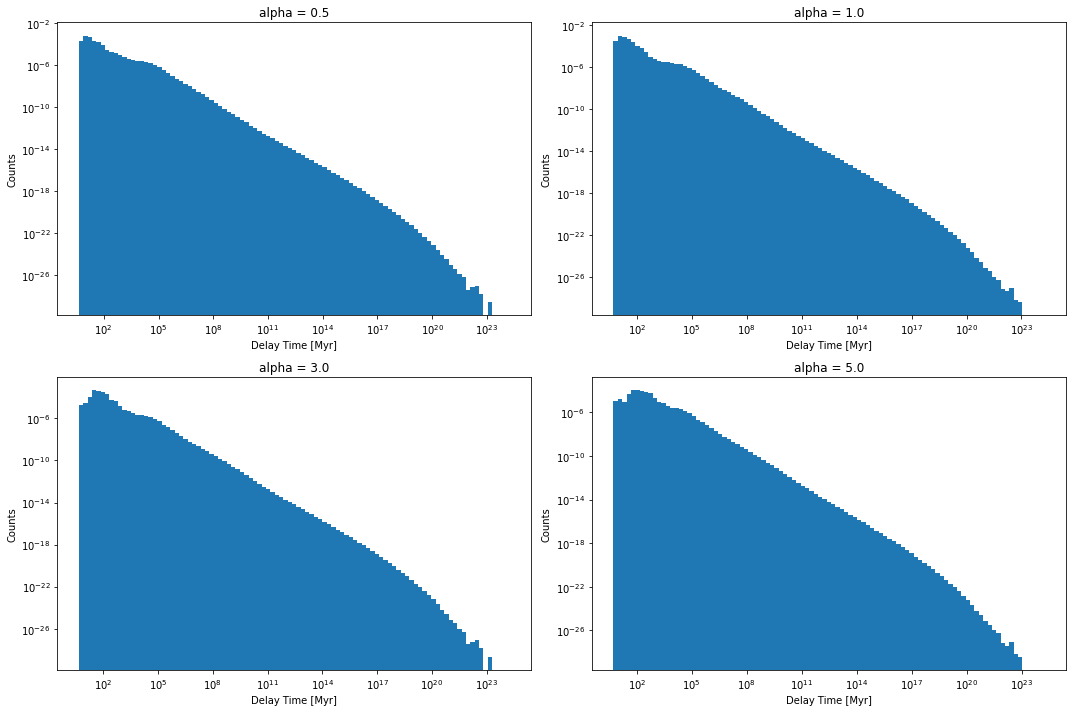

In [53]:
popt, pcov, bin_centers, entries = (np.empty(shape=(2,2), dtype=object) for i in range(4))

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    #ax[x,y].hist(alpha_df[key][(alpha_df[key].Delay_Time<1e18)].Delay_Time, bins=200)
    #b                         = np.histogram_bin_edges(alpha_df[key][(alpha_df[key].Delay_Time<1e18)].Delay_Time, bins='rice')
    b                         = np.logspace(np.log10(min(alpha_df[key].Delay_Time+alpha_df[key].BWorldtime)), np.log10(max(alpha_df[key].Delay_Time+alpha_df[key].BWorldtime)), 100)
    entries[x,y], edges, _    = ax[x,y].hist(            alpha_df[key].Delay_Time+alpha_df[key].BWorldtime, bins=b, density=True)

    # calculate bin centers
    bin_centers[x,y]          = 0.5 * (edges[:-1] + edges[1:])
    popt[x,y], pcov[x,y]      = curve_fit(power_law, bin_centers[x,y][np.where((bin_centers[x,y]>1e9) & (bin_centers[x,y]<1e19))],
                                                     entries[x,y][    np.where((bin_centers[x,y]>1e9) & (bin_centers[x,y]<1e19))], p0=(.005, 18))
    #popt[x,y], pcov[x,y]      = curve_fit(power_law, bin_centers[x,y], entries[x,y], p0=(.005, 18))

    #ax[x,y].hist(alpha_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('alpha = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('PDF')

    y += 1
    if y == 2:
        x +=1
        y = 0

fig.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

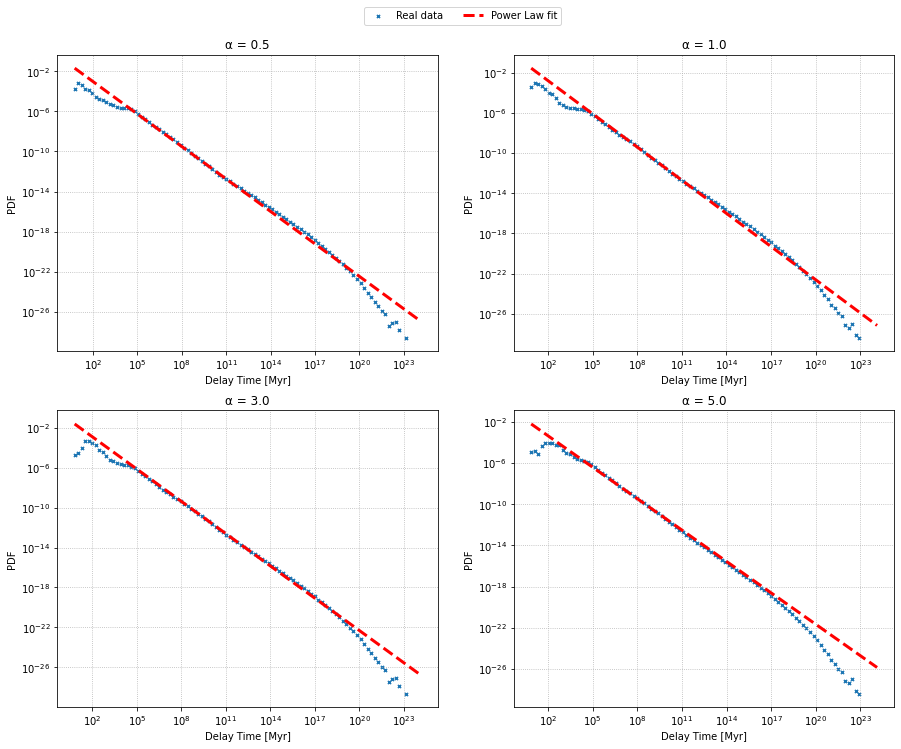

In [54]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].scatter(bin_centers[x,y], entries[x,y], s=10, marker='x')
    ax[x,y].plot(bin_centers[x,y], power_law(bin_centers[x,y], popt[x,y][0], popt[x,y][1]), 'r--', lw=3)

    ax[x,y].grid(ls='dotted')

    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('α = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('PDF')

    y += 1
    if y == 2:
        x +=1
        y = 0

labels = ['Real data', 'Power Law fit']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)
#fig.tight_layout()
fig.savefig("figures/Fit_alpha.png")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

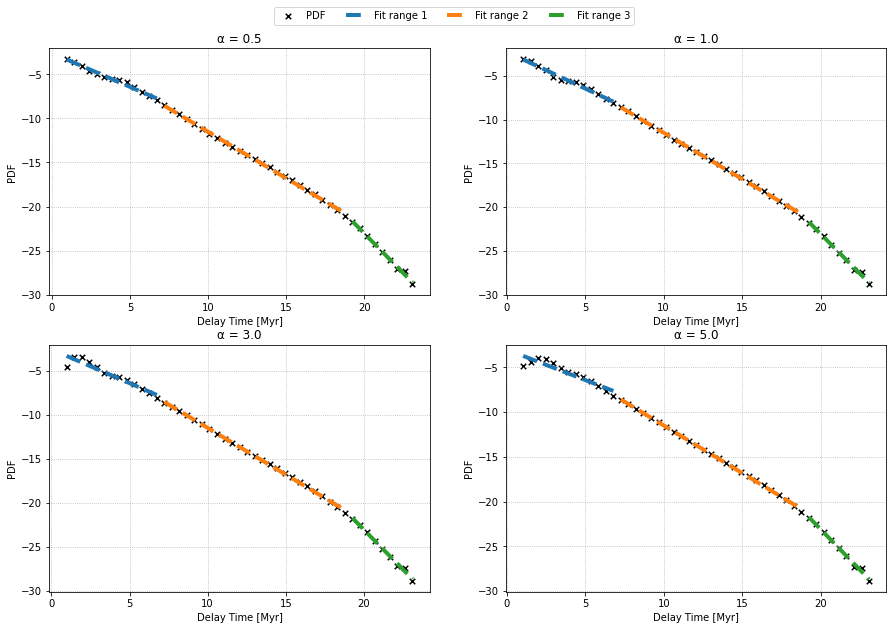

In [57]:
bin_centers, entries = (np.empty(shape=(2,2),   dtype=object) for i in range(2))
results              =  np.empty(shape=(2,2,3), dtype=object)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    #b                         = np.histogram_bin_edges(alpha_df[key][(alpha_df[key].Delay_Time+alpha_df[key].BWorldtime<1e18)].Delay_Time, bins='rice')
    b                         = np.logspace(np.log10(min(alpha_df[key].Delay_Time+alpha_df[key].BWorldtime)), np.log10(max(alpha_df[key].Delay_Time+alpha_df[key].BWorldtime)), 50)
    entries[x,y], edges,    = np.histogram(            alpha_df[key].Delay_Time+alpha_df[key].BWorldtime,   bins=b, density=True                 )

    # calculate bin centers
    bin_centers[x,y]          = 0.5 * (edges[:-1] + edges[1:])

    ax[x,y].scatter(np.log10(bin_centers[x,y][entries[x,y]!=0]), np.log10(entries[x,y][entries[x,y]!=0]), s=30, marker='x', color='black')

    mask = np.empty(shape=3, dtype=object)
    for i in range(len(results[x,y])):

        mask[i] = np.where((bin_centers[x,y]>xstep[i]) & (bin_centers[x,y]<xstep[i+1]) & (entries[x,y]!=0))
        results[x,y,i] = stats.linregress(np.log10(bin_centers[x,y][mask[i]]), np.log10(entries[x,y][mask[i]]))

        ax[x,y].plot(np.log10(bin_centers[x,y][mask[i]]), results[x,y,i].intercept + results[x,y,i].slope*np.log10(bin_centers[x,y][mask[i]]), '--', lw=4)

    ax[x,y].set_title('α = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('PDF')

    ax[x,y].grid(ls='dotted')

    y += 1
    if y == 2:
        x +=1
        y = 0

labels=['PDF', "Fit range 1", "Fit range 2", "Fit range 3"]
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

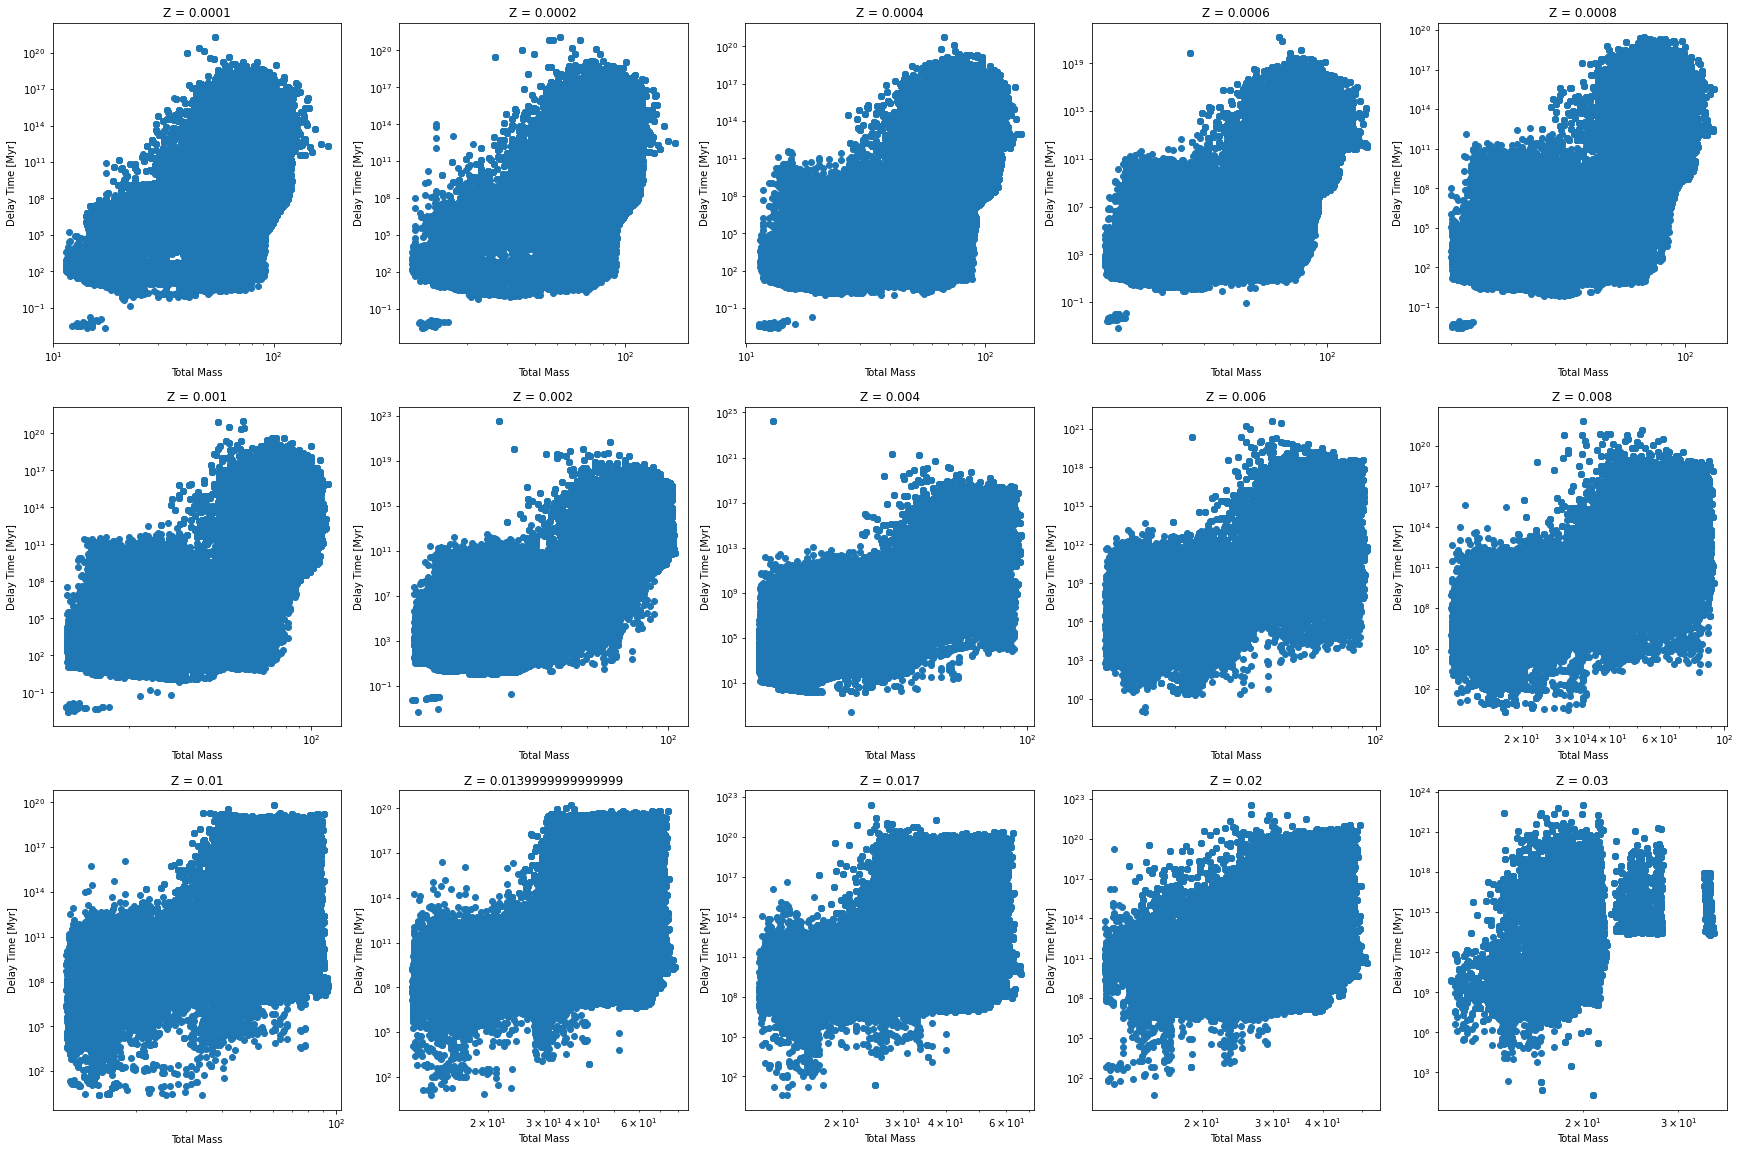

In [58]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(Z_df[key].Mass_0+Z_df[key].Mass_1, Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Total Mass')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

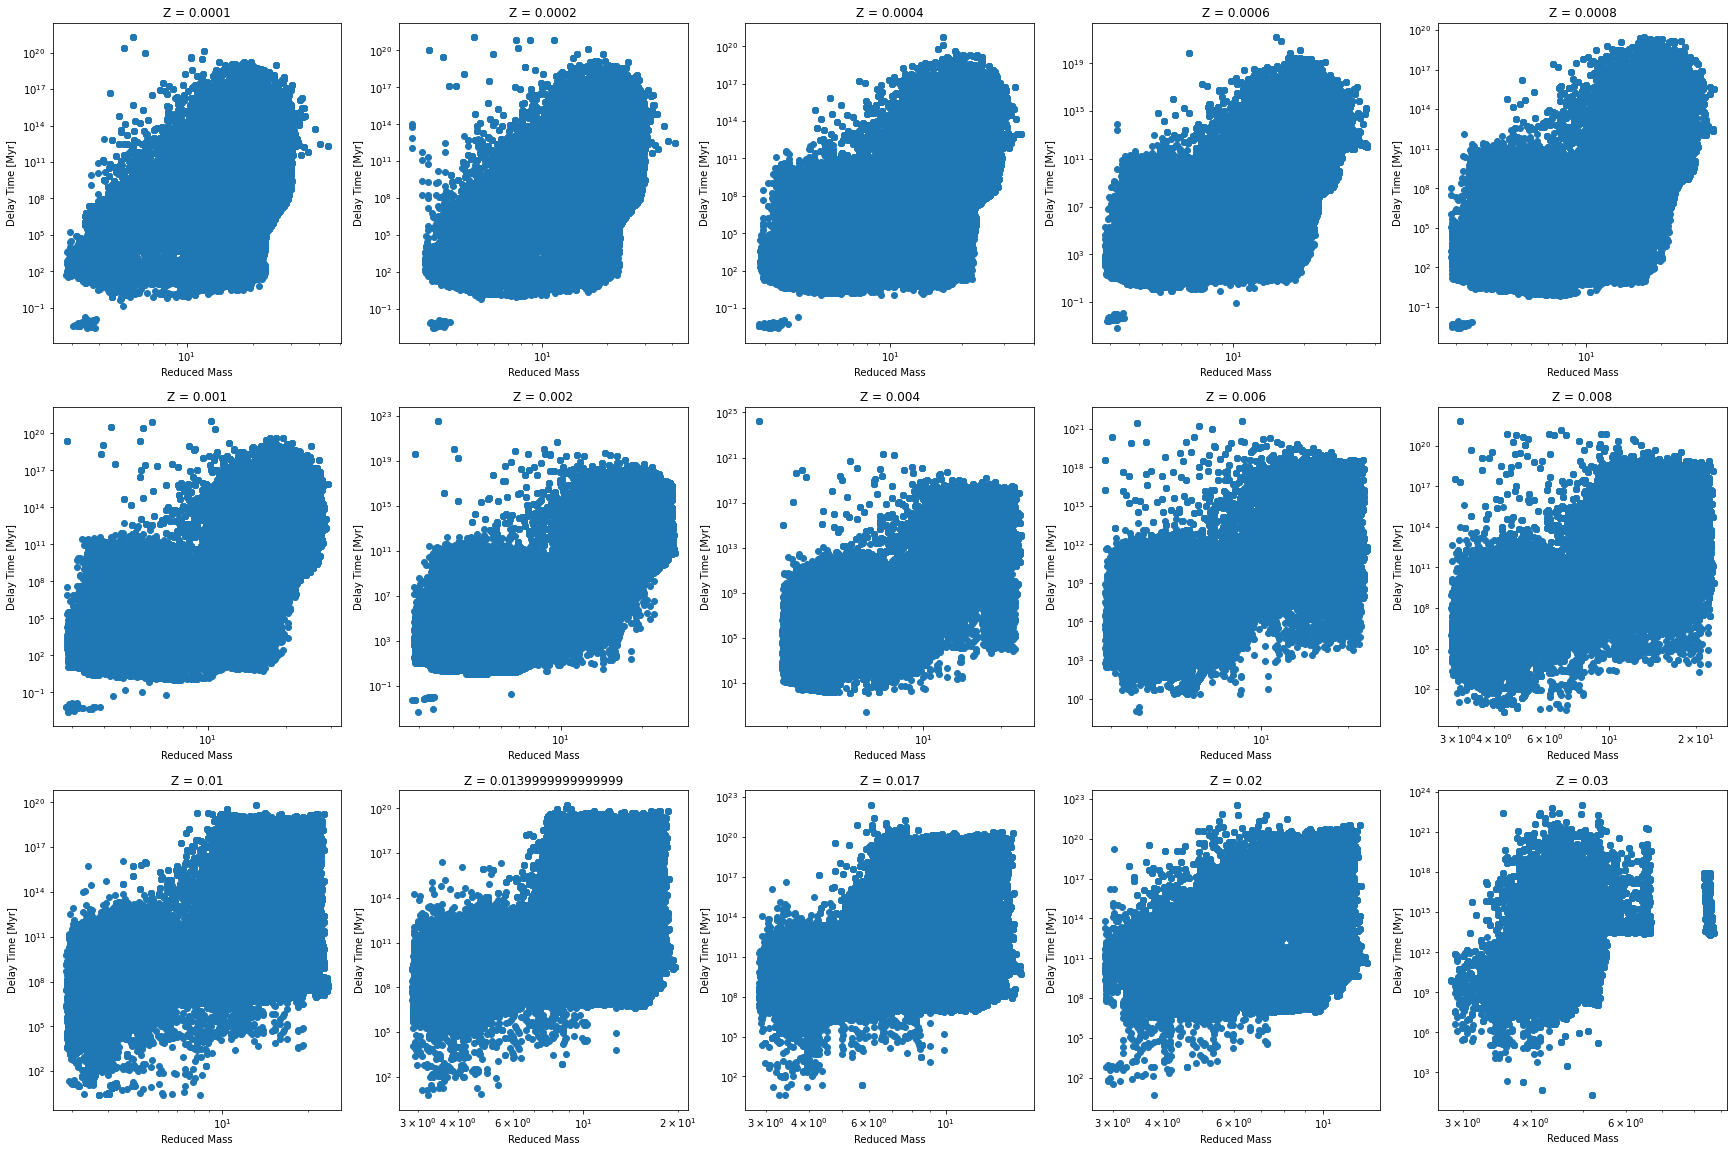

In [59]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(Z_df[key].Mass_reduced, Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Reduced Mass')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

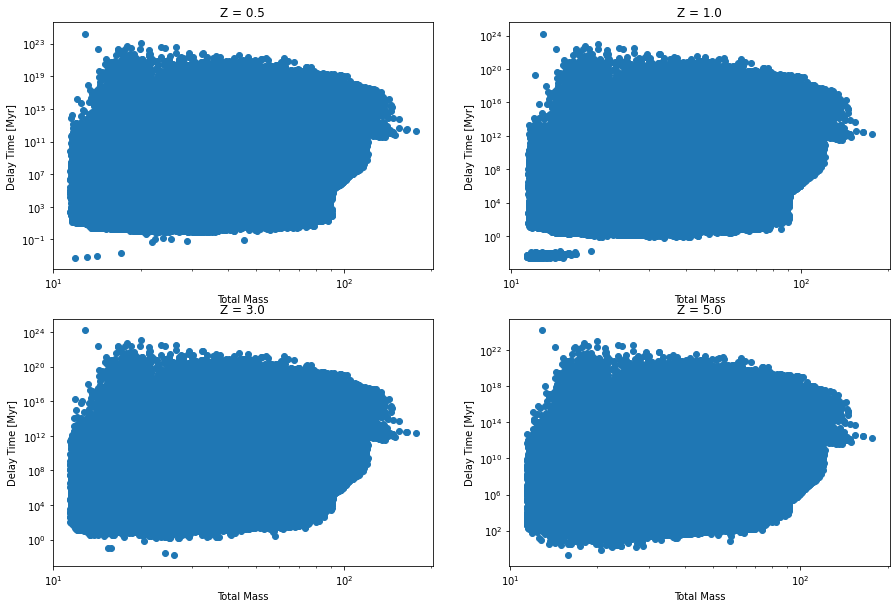

In [60]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].scatter(alpha_df[key].Mass_0+alpha_df[key].Mass_1, alpha_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Total Mass')

    y += 1
    if y == 2:
        x +=1
        y = 0

plt.show